# Performance Analysis of Hedge Fund Daily Returns using Multi-variate Linear Regression
In this notebook, we perform analysis on 
- Fama-French 5 Factors Model and 
- 10 Industry Portfolios Model

**AQR**: [QMNIX](https://funds.aqr.com/funds/alternatives/aqr-equity-market-neutral-fund/qmnix#about)
- AQR Equity Market Neutral Fund Class I (Ticker: QMNIX). 
- Get the series that is adjusted for both dividends and splits (i.e. **Adj Close**)
- Obtain prices from Yahoo Finance, and calculate daily log returns
- Daily returns from 2014-10-10 to 2021-04-15

***Some Notes on QMNIX***:
- Investment Objective
    - Seeks positive absolute returns.
- Seeking Positive Returns Uncorrelated to Equity Markets
    - The Equity Market Neutral Fund seeks to generate positive returns without exposing investors to the risks of equity markets by buying, or going long, stocks expected to perform well and selling short stocks expected to perform relatively poorly.
- Investment Approach
    - The Fund seeks to deliver positive absolute returns by taking long and short positions in equity and equity-related instruments that are deemed to be relatively attractive or unattractive, respectively, based on AQR's investment models.
    - The Fund is designed to be market neutral; positions in the portfolio are chosen so that the long side exposure is offset by the short side. The portfolio is constructed based on AQR's global stock selection model, employing value, momentum, quality, and other proprietary factors to indicate which industries, sectors and companies are conditionally attractive or unattractive.
- Why invest in QMNIX
    - Seeks Attractive Risk-Adjusted Returns
        - The Fund targets the spread between long and short positions, while remaining insulated from the large swings of equity markets. It seeks to deliver positive returns at a lower volatility, resulting in compelling risk-adjusted returns for investors.
    - Opportunity to Perform in Rising and Falling Markets
        - The Fund seeks capital appreciation regardless of overall market direction. Over any short-term period, neither the direction nor the magnitude of the stock market tends to impact the strategy.
    - Greater Portfolio Diversification
        - The Fund invests in stocks across industries and geographic regions. It may provide additional diversification benefits such as lowering the overall portfolio’s volatility, reducing drawdowns and improving risk-adjusted returns.

### My work includes:
For each of FF5 and 10 Portfolio models:
- Data import and cleansing
- EDA with statistics, plots and stationary test
- OLS fitting, and results interpreting
- Classical Linear Regression assumptions investigating
- Conclusion

----------
## PART ONE: Analysis on Fama-French 5 Factors Model
### Datasets:
**FF5**:
- Monthly data of the [Fama-French 5 Factor model](https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/f-f_5_factors_2x3.html)
- [Ken French data library](https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html)
- 1963-07-01 to 2021-02-26
- The Fama/French 5 factors (2x3) are constructed using the 6 value-weight portfolios formed on size and book-to-market, the 6 value-weight portfolios formed on size and operating profitability, and the 6 value-weight portfolios formed on size and investment. (See the description of the 6 size/book-to-market, size/operating profitability, size/investment portfolios.)

### FF5 Model:

- Testing CAPM or related models:
    - It makes sense to regress (1) the **excess returns** of the fund on (2) the **excess returns** of the market and other factors. This type of setup is often common when testing CAPM and related models.
    - When we want to do risk premia forecasting, how is the asset going to outperform the market?
    - **Excess return** of the market is a measure of the equity risk premium, i.e. the risk premium associated with equities above that of the risk-free rate. 
    $$R_{\text{asset}}-R_f = \beta_1*(R_{\text{mkt}}-R_f) + \beta_2 * \text{factor}_2 + ...$$

- Market model with multiple factors:
    - Here, in this notebook, we are regressing (1) the returns of the fund on (2) the returns of the market and other factors, instead of excess return. 
    - When we want to do return forecasting, find factors that have influence on our target asset
    - This type of setup is often referred to as the market model (with multiple factors). 
     $$R_{\text{asset}}= \beta_1*R_{\text{mkt}} + \beta_2 * \text{factor}_2 + ...$$

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format ='retina'
import seaborn as sns 
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import statsmodels.stats.api as sms
sns.set_style('darkgrid')
sns.mpl.rcParams['figure.figsize'] = (20.0, 9.0)
import warnings
warnings.filterwarnings('ignore')

C:\Users\xxxli\Anaconda3\envs\mysixenv\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\xxxli\Anaconda3\envs\mysixenv\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
C:\Users\xxxli\Anaconda3\envs\mysixenv\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


### I. Download and import data
These are common questions about dataset: What is the format? How is the data reported? What are its units? etc. It is part of the problem for analyst to figure it out in a real woring environment.  

### I.A) Fama-French 5 Factors daily data
- web scraping
- to understand FF5:
    - **SMB (Small Minus Big): size, or market capitalization risk**
        - the average return on the nine small stock portfolios minus the average return on the nine big stock portfolios,
        - SMB(B/M) = 1/3 (Small Value + Small Neutral + Small Growth) - 1/3 (Big Value + Big Neutral + Big Growth).
        - SMB(OP) = 1/3 (Small Robust + Small Neutral + Small Weak) - 1/3 (Big Robust + Big Neutral + Big Weak).
        - SMB(INV) = 1/3 (Small Conservative + Small Neutral + Small Aggressive) - 1/3 (Big Conservative + Big Neutral + Big Aggressive).
        - SMB = 1/3 ( SMB(B/M) + SMB(OP) + SMB(INV) ).
    - **HML (High Minus Low): Book-to-market B/M ratio risk** is the average return on the two value portfolios minus the average return on the two growth portfolios,
        - HML = 1/2 (Small Value + Big Value) - 1/2 (Small Growth + Big Growth). 
    - **RMW (Robust Minus Weak): profitability risk** 
        - the average return on the two robust operating profitability portfolios minus the average return on the two weak operating profitability portfolios,
        - RMW = 1/2 (Small Robust + Big Robust) - 1/2 (Small Weak + Big Weak).	 
    - **CMA (Conservative Minus Aggressive): Investment Quality risk** 
        - is the average return on the two conservative investment portfolios minus the average return on the two aggressive investment portfolios,
        - CMA = 1/2 (Small Conservative + Big Conservative) - 1/2 (Small Aggressive + Big Aggressive).
    - **$R_m-R_f$: (excess return on the market): market risk**
        - value-weight return of all CRSP firms incorporated in the US and listed on the NYSE, AMEX, or NASDAQ that have a CRSP share code of 10 or 11 at the beginning of month t, good shares and price data at the beginning of t, and good return data for t minus the one-month Treasury bill rate (from Ibbotson Associates).

In [2]:
import pandas_datareader.data as web
FF5_m = web.DataReader('F-F_Research_Data_5_Factors_2x3_daily', 'famafrench', start = '1963-07-01', end = '2021-02-26')[0]
FF5_m['Mkt-RF'] = FF5_m['Mkt-RF'] + FF5_m['RF']
FF5_m.rename(columns={'Mkt-RF':'MktRet'},inplace=True)
FF5_m_RF = FF5_m.copy(deep=True)
FF5_m.drop(columns='RF', inplace=True)
FF5_m

,MktRet,SMB,HML,RMW,CMA
Date,,,,,
1963-07-01,-0.658,0.00,-0.34,-0.01,0.15
1963-07-02,0.802,-0.27,0.27,-0.07,-0.19
1963-07-03,0.642,-0.17,-0.10,0.17,-0.33
1963-07-05,0.412,0.08,-0.27,0.08,-0.33
1963-07-08,-0.618,0.04,-0.19,-0.29,0.13
...,...,...,...,...,...
2021-02-22,-1.120,0.68,3.14,1.66,0.90
2021-02-23,-0.150,-1.05,0.90,1.08,-0.19
2021-02-24,1.150,1.48,1.34,-0.29,0.32


In [3]:
print(f"FF5 daily:{FF5_m.shape}")
print(f"missing values: {FF5_m.isnull().any().sum()}")
b1, e1 = FF5_m.index[0], FF5_m.index[-1]
print(f"Starting from {str(b1)[:10]} to {str(e1)[:10]}")

FF5 daily:(14514, 5)
missing values: 0
Starting from 1963-07-01 to 2021-02-26


### I.B) AQR daily prices

In [4]:
import yfinance as yf
prices_m = yf.download('QMNIX', period='max', progress=False, interval='1d')
QMNIX_m = prices_m[['Adj Close']]
QMNIX_m

,Adj Close
Date,
2014-10-09,8.682810
2014-10-10,8.709042
2014-10-13,8.700297
2014-10-14,8.656576
2014-10-15,8.604114
...,...
2021-04-12,7.300000
2021-04-13,7.260000
2021-04-14,7.260000


In [5]:
# cleansing
to_drop = QMNIX_m[QMNIX_m.isnull().any(axis=1)] # let's see nan
QMNIX_m.drop(index=to_drop.index, inplace=True)
print(f"QMNIX daily prices:{QMNIX_m.shape}")
print(f"There are {QMNIX_m.isnull().any().sum()} missing values")
b2, e2 = QMNIX_m.index[0], QMNIX_m.index[-1]
print(f"Starting from {str(b2)[:10]}, to {str(e2)[:10]}")

QMNIX daily prices:(1641, 1)
There are 0 missing values
Starting from 2014-10-09, to 2021-04-16


### I.C) AQR monthly returns

In [6]:
def price2ret(price_df, retType='simple'):
    ''' Convert price to return.

    Args
    ----------
    price_df: pd.DataFrame
    retype: str
        simple: arithmetic return, p2/p1 - 1, same as pct_change()
        log: logarithmetic return, log(p2/p1)
    
    Returns
    ----------
    return: pd.DataFrame
    
    '''
    p = price_df.copy(deep=True)
    if retType == 'simple':
        r = (p/p.shift(1))-1
    else: 
        r = np.log(p/p.shift(1))
    p['Return'] = r
    return p.dropna()[['Return']]

In [7]:
AQR_m = price2ret(QMNIX_m,'log')
print(f"AQR daily return: {AQR_m.shape}")
print(f"missing values: {AQR_m.isnull().any().sum()}")
b3, e3 = AQR_m.index[0], AQR_m.index[-1]
print(f"Starting from {str(b3)[:10]} to {str(e3)[:10]}")

AQR daily return: (1640, 1)
missing values: 0
Starting from 2014-10-10 to 2021-04-16


### II. Exploratory Data Analysis (EDA)

Data Imported:
- `FF5_m`: daily FF5 factors data
- `AQR_m`: AQR daily log returns

EDA components:
- time series plots (visualization)
- scatter plots (Factor Correlation)
- distribution and summary statistics (mean, std, skew, kurtosis, max, min)
- time series stationary test
- make conclusions and discuss any noteworthy results

### II.A) FF5

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002C5E1762160>,
      dtype=object)

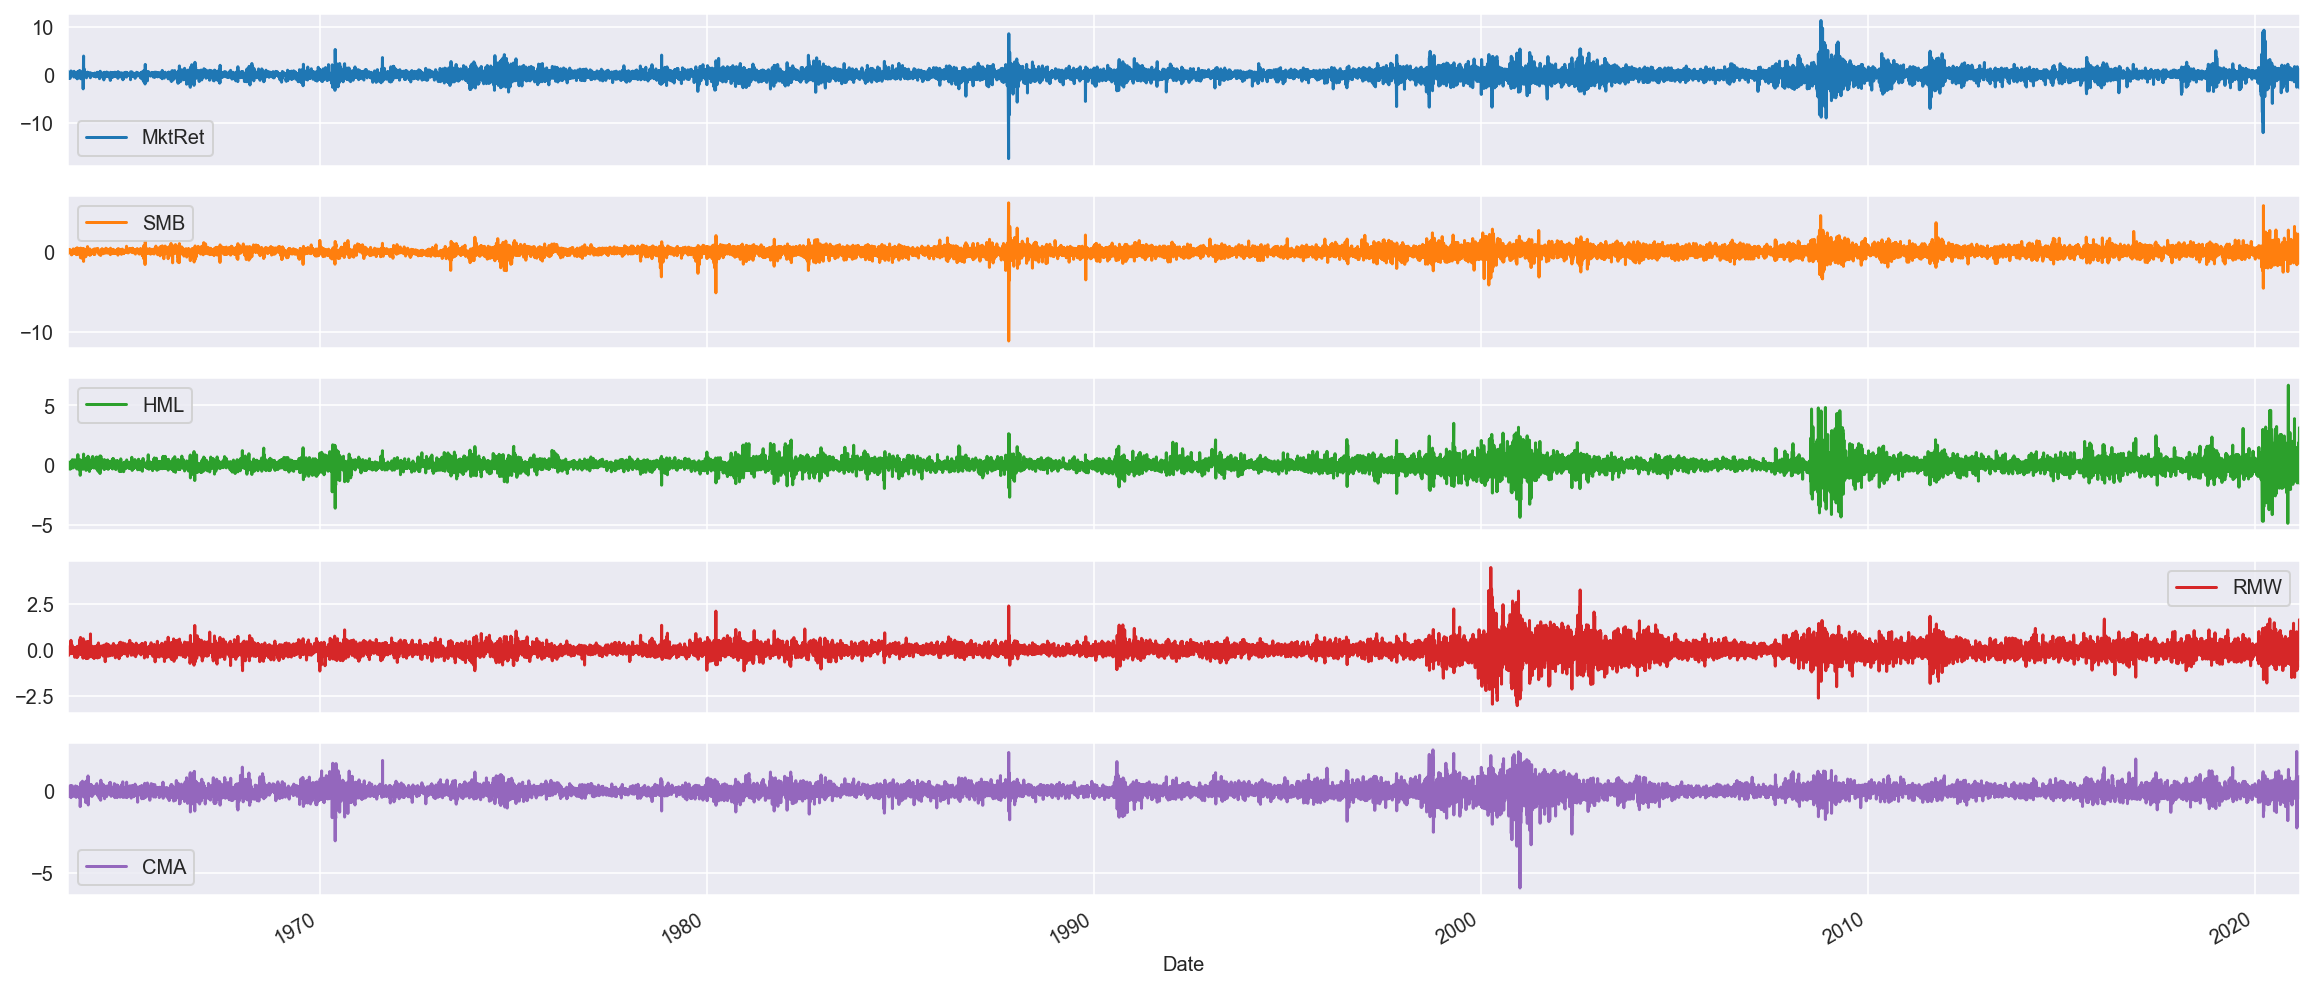

In [8]:
FF5_m.plot(subplots=True)

According to these time series plots, we can see some abnormal periods such as 2000 and 2020. Also, compared with `MktRet`, `SMB` seems to be stable while `HML`, `RMW` and `CMA` are more volatile. What's more, all factor series are in similar pattern.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002C5B4E12F60>,
      dtype=object)

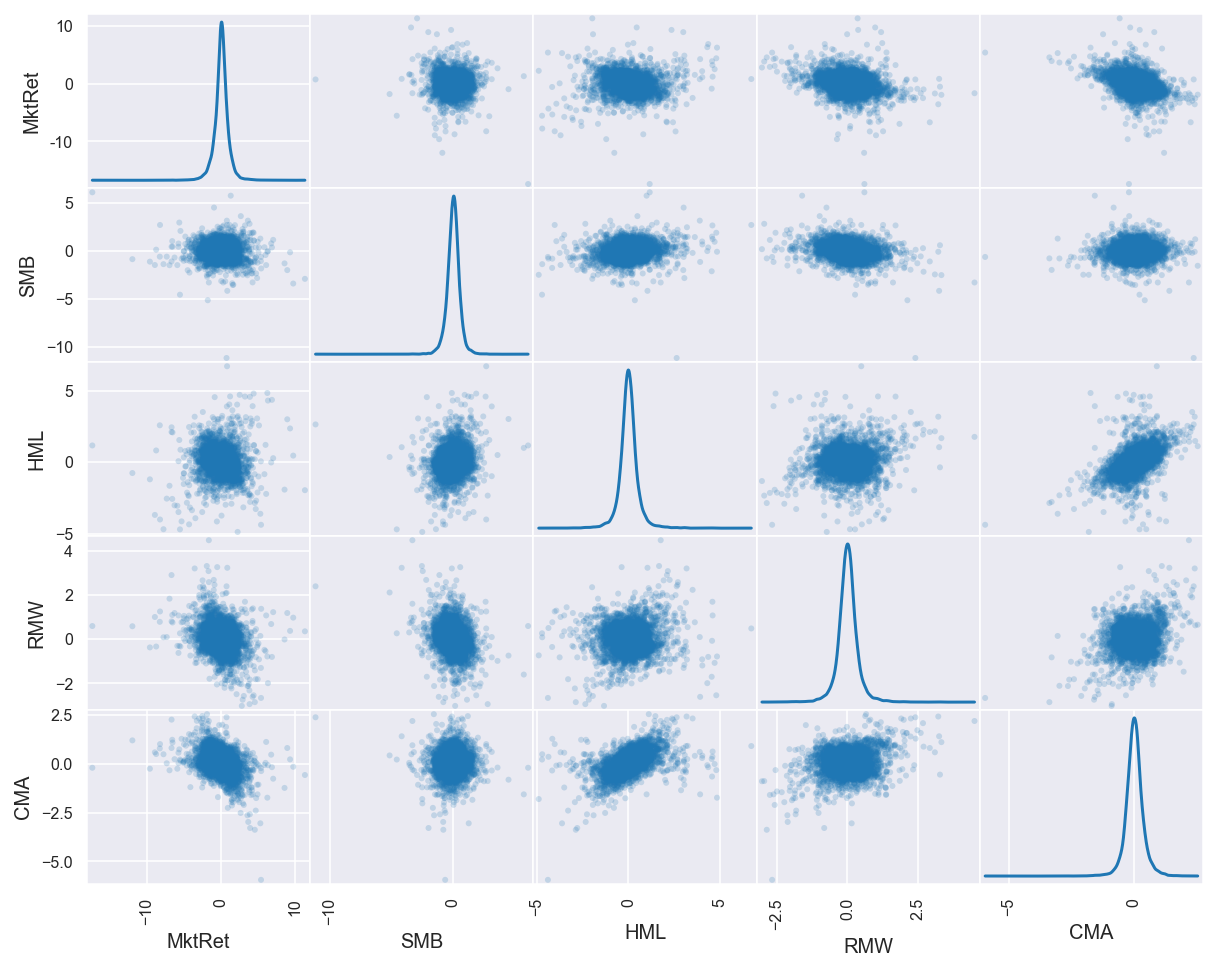

In [9]:
# among factor columns
pd.plotting.scatter_matrix(FF5_m, alpha=0.2, figsize=(10,8), diagonal='kde')

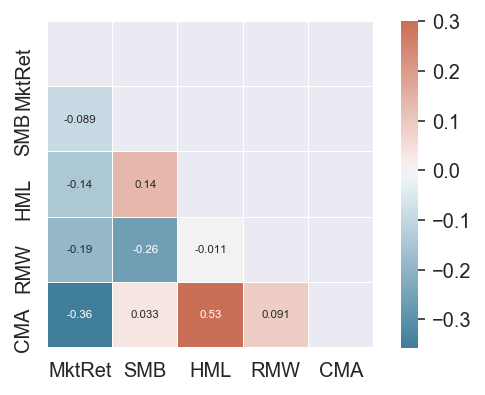

In [10]:
C = FF5_m.corr() # see correlation
mask = np.triu(np.ones_like(C, dtype=bool)) # Generate a mask for the upper triangle
f, ax = plt.subplots(figsize=(5, 3)) # Set up the matplotlib figure
cmap = sns.diverging_palette(230, 20, as_cmap=True) # Generate a custom diverging colormap
sns.heatmap(C, annot=True, annot_kws = {'fontsize':'xx-small'} ,mask=mask, cmap=cmap, vmax=.3, center=0,square=True, linewidths=.01) # Draw the heatmap with the mask and correct aspect ratio

In [11]:
FF5_m.agg(['mean','std','skew','kurtosis','max','min'])

,MktRet,SMB,HML,RMW,CMA
mean,0.045125,0.008258,0.013365,0.012177,0.012545
std,1.014176,0.534342,0.548423,0.376501,0.367682
skew,-0.566871,-0.757686,0.369111,0.299968,-0.366114
kurtosis,16.708010,19.628894,12.832247,9.909156,10.692202
max,11.354000,6.080000,6.700000,4.490000,2.530000
min,-17.413000,-11.170000,-4.890000,-3.020000,-5.940000


FF5 Findings:
- Something strange happened around 2000 and 2020 for example, can do further research.
- There are some factors are sort of correlated with other, such as `HML` and `CMA`, but still under reasonable range.
- all factors are with a mean about to 0
- `MktRet` has highest variance, `SMB` and `HML` come in the second place, then `RWM` and `CMA`
- None of them are perfectly normal; either skewed to left or right slightly; all with fat tails
    - Symmetric or not:
        - Negative skew: the data are skewed to left
        - Positive skew: the data are skewed to right
    - Tails:
        - kurtosis > 3: fat-tail
        - kurtosis < 3: fat-tail

### II.B) AQR daily returns

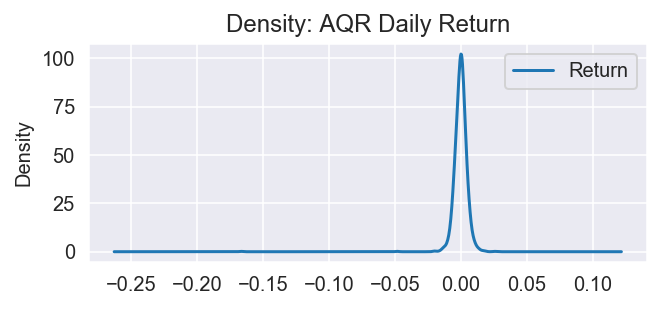

In [12]:
AQR_m.plot(kind='kde', figsize=(5,2), title='Density: AQR Daily Return')

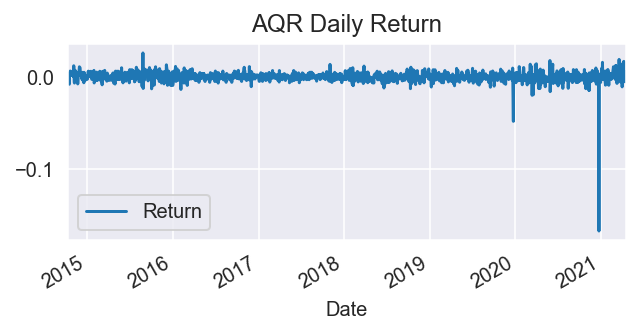

In [13]:
AQR_m.plot(figsize=(5,2), title='AQR Daily Return')

In [14]:
AQR_m.agg(['mean','std','skew','kurtosis','max','min'])

,Return
mean,-0.000107
std,0.006083
skew,-12.784689
kurtosis,345.100961
max,0.025619
min,-0.166690


AQR Daily Returns Findings:
- Pay attention on extremes, such as what impacted the fund at the time just before 2021.
- Do more research to see if we can delete that value to enpower our predict model
- Mean is zero
- volatility is small. This is make sense when we go back to look at the fund description. People would like to invest in it when do not want to expose themselves to risk pretty much.
- values are highly skewed to the left
- fat tail is outstanding.

### II.C) Relationship between FF5 and AQR returns:

In [15]:
start = max(b1, b3)
end = min(e1, e3)
print('For scatter plots, we need consistent start/end dates for two datasets:')
print('start_date: ', str(start)[:10])
print('end_date: ', str(end)[:10])

FF5_m_2 = FF5_m.loc[start:end]
AQR_m_2 = AQR_m.loc[start:end]

data_all_m = pd.merge(AQR_m_2, FF5_m_2, left_index=True, right_index=True)
print(data_all_m.shape)
data_all_m

For scatter plots, we need consistent start/end dates for two datasets:
start_date:  2014-10-10
end_date:  2021-02-26
(1606, 6)


,Return,MktRet,SMB,HML,RMW,CMA
Date,,,,,,
2014-10-10,0.003017,-1.30,-0.07,0.51,0.76,0.37
2014-10-13,-0.001005,-1.59,1.31,0.49,-0.32,0.22
2014-10-14,-0.005038,0.28,0.82,-0.12,0.01,0.07
2014-10-15,-0.006079,-0.53,1.65,-1.33,-0.48,-0.59
2014-10-16,-0.008163,0.22,1.07,0.24,-0.45,0.12
...,...,...,...,...,...,...
2021-02-22,0.010712,-1.12,0.68,3.14,1.66,0.90
2021-02-23,0.000000,-0.15,-1.05,0.90,1.08,-0.19
2021-02-24,0.004556,1.15,1.48,1.34,-0.29,0.32


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002C5BA01A7F0>,
      dtype=object)

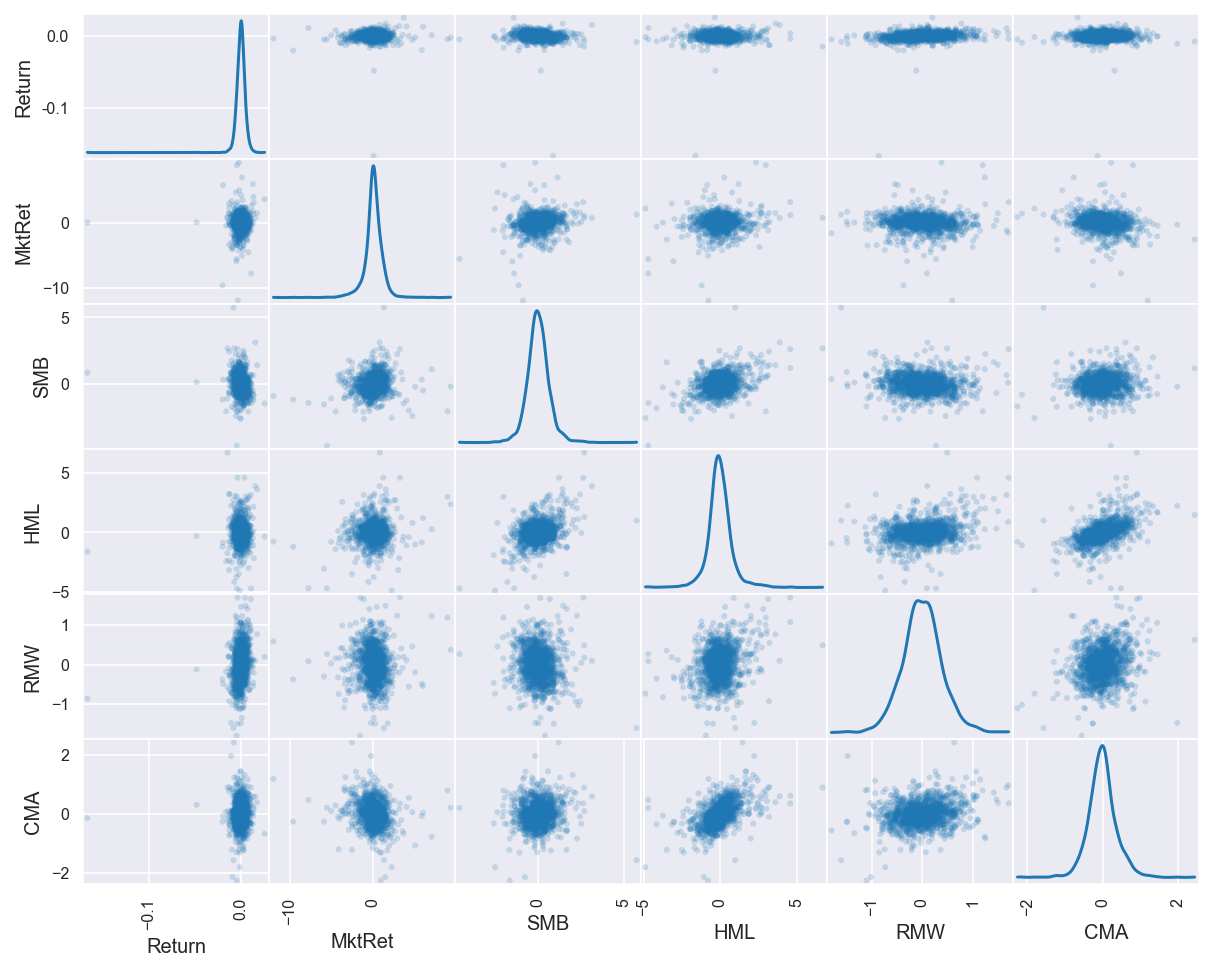

In [54]:
pd.plotting.scatter_matrix(data_all_m, alpha=0.2, figsize=(10,8), diagonal='kde')

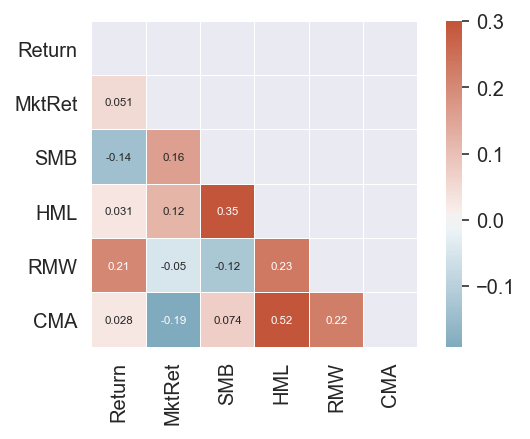

In [56]:
# correlations
V = data_all_m.corr()
mask = np.triu(np.ones_like(V, dtype=bool)) # Generate a mask for the upper triangle
f, ax = plt.subplots(figsize=(5, 3)) # Set up the matplotlib figure
cmap = sns.diverging_palette(230, 20, as_cmap=True) # Generate a custom diverging colormap
sns.heatmap(V, annot=True, annot_kws = {'fontsize':'xx-small'} ,mask=mask, cmap=cmap, vmax=.3, center=0,square=True, linewidths=.01) # Draw the heatmap with the mask and correct aspect ratio

Factors and AQR return Findings:
- With daliy data, we see
    - fators are not highly correlated with each other. The highest correlation is between `CMA` and `HML` = 0.52, which is still under reasonable region. Therefore, we can tell that using these 5 factors to model asset returns is a great try. 
    - AQR fund return is not highly correlated with 5 factors. 
    - Comparing 5 factors, we see that AQR fund is mostly related with `RMW`, which means the fund return is more likely affected by Robust-Minus-Weak, the profitibility factor.

### II.D) Perform tests for stationarity of all data series
**Augmented Dickey-Fuller test**
- a type of statistical test called a unit root test.
- The intuition behind a unit root test is that it determines how strongly a time series is defined by a trend.
- There are a number of unit root tests and the Augmented Dickey-Fuller may be one of the more widely used. It uses an autoregressive model and optimizes an information criterion across multiple different lag values.

Hypothesis:
- **Null Hypothesis (H0)**: the time series can be represented by a unit root, and hence is **non-stationary**, has some time dependent structure.
- **Alternate Hypothesis (Ha)**: does not have a unit root, meaning **stationary**, not have time-dependent structure.

Interpret:  
- **p-value > 0.05**: Fail to reject the null hypothesis (H0), the data has a unit root and is **non-stationary**.
- **p-value <= 0.05**: Reject the null hypothesis (H0), the data does not have a unit root and is **stationary**.

In [18]:
from statsmodels.tsa.stattools import adfuller
sig = 0.05
print(f'Performing ADF test... at significant level = {sig}')
for i in FF5_m_RF.columns:
    print('-'*15)
    print(f'{i}')
    result = adfuller(FF5_m_RF[i])
    print(f'  p-value: {result[1]}')
    if result[1] > sig:
        print('  Result: non-stationary')
    else:
        print('  Result: stationary')

for i in AQR_m.columns:
    print('-'*15)
    print(f'{i}')
    result = adfuller(AQR_m[i])
    print(f'  p-value: {result[1]}')
    if result[1] > sig:
        print('  Result: non-stationary')
    else:
        print('  Result: stationary')

Performing ADF test... at significant level = 0.05
---------------
MktRet
  p-value: 0.0
  Result: stationary
---------------
SMB
  p-value: 0.0
  Result: stationary
---------------
HML
  p-value: 2.6820591776272696e-29
  Result: stationary
---------------
RMW
  p-value: 5.751878323804821e-30
  Result: stationary
---------------
CMA
  p-value: 9.596981375054592e-30
  Result: stationary
---------------
RF
  p-value: 0.169546798461722
  Result: non-stationary
---------------
Return
  p-value: 0.0
  Result: stationary


Stationary Finding:
- Based on ADF test, the time series of risk-free rate `RF` is the only one that is non-stationary. It may have some time-dependent trends or seasonalities. This is reasonable since most economicFor further forecasting modeling, we can employ models such as additive seasonal ARIMA. 
- All others, including AQR fund returns, `MktRet`, `SMB`, `HML`, `RMW` and `CMA`, are stationary without time-dependent properties.

Let's take a look of this risk-free rate:
- 1-month TBill return from Ibbotson and Associates

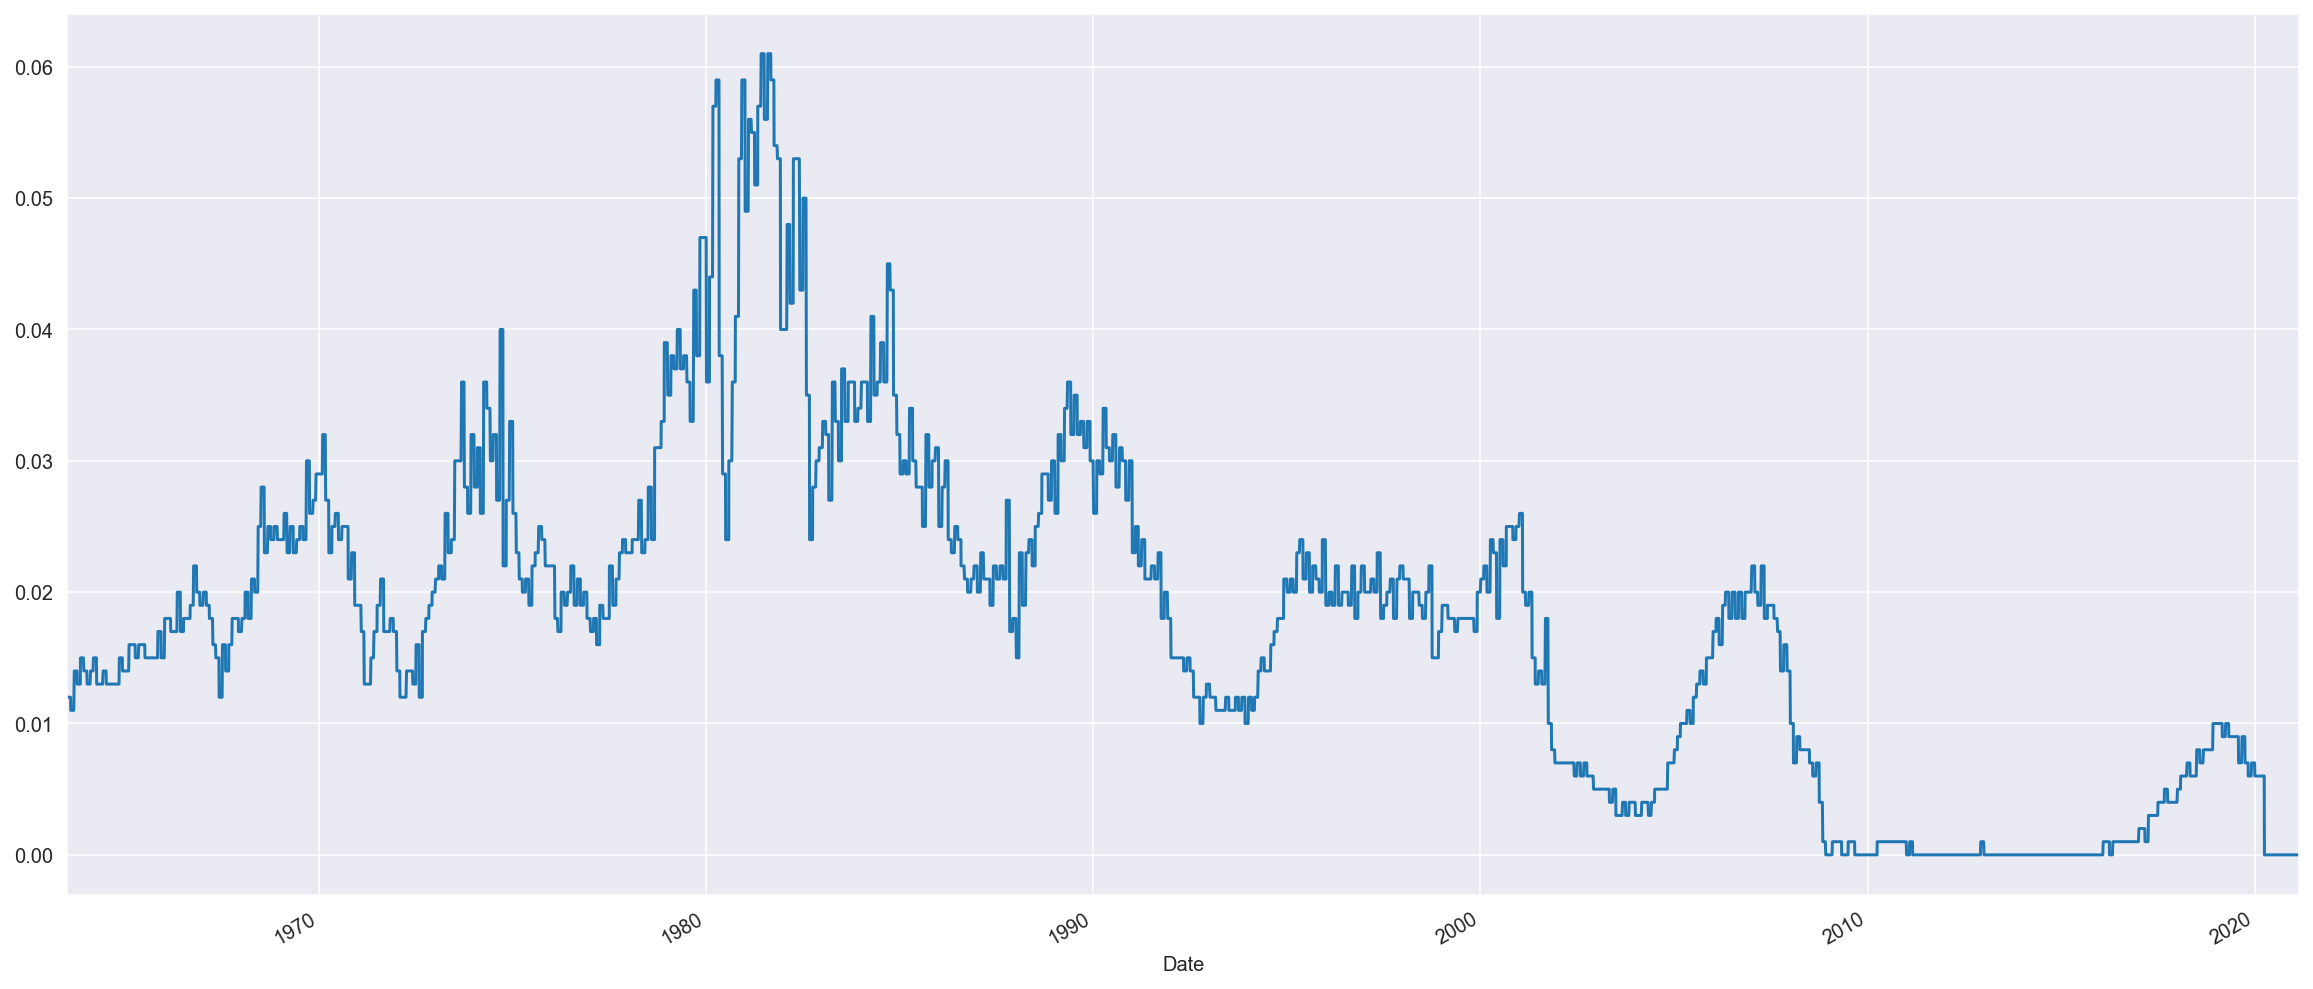

In [19]:
FF5_m_RF['RF'].plot()

We leave the time series analysis and modeling here for further work, since we are not going to use `RF` in this notebook.

### III. Regression (Factor Exposure)
- Regress AQR daily returns on the 5 factors `MktRet`, `SMB`, `HML`, `RMW`, `CMA`
- Discuss the regression results, including 
    - t-test
    - F-test
    - $R^2$
    - Is the intercept statistically different from 0?

**Model**
$$\text{Return}_t = a + b*\text{MktRet}_t + s*\text{SMB}_t + h*\text{HML}_t + r*\text{RMW}_t + c*\text{CMA}_t + \epsilon_t$$

In [20]:
# regressors: 5 Factors
X_m = data_all_m[data_all_m.columns[1:]]
# response variable: Returns of QMNIX Monthly   
y_m = data_all_m[['Return']]

In [21]:
# Running OLS model:
import statsmodels.api as sm
X_m = sm.add_constant(X_m) # add interception
model_m = sm.OLS(y_m, X_m, missing='raise')
result_m = model_m.fit()
tstat_m = result_m.tvalues
coeff_m = result_m.params
fitted_m = result_m.fittedvalues
resid_m = result_m.resid
result_m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Return   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     21.33
Date:                Sun, 18 Apr 2021   Prob (F-statistic):           1.03e-20
Time:                        11:07:17   Log-Likelihood:                 5977.4
No. Observations:                1606   AIC:                        -1.194e+04
Df Residuals:                    1600   BIC:                        -1.191e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.000     -1.241      0.215      -0.000       0.000
MktRet         0.0004      0.000      3.066      0.002       0.000       0.001
SMB           -0.0013      0.000     -5.210      0.000      -0.002      -0.001
HML            0.0002      0.000      0.933      0.351      -0.000       0.001
RMW            0.0028      0.000      7.244      0.000       0.002       0.004
CMA        -5.784e-05      0.000     -0.121      0.904      -0.001       0.001
==============================================================================
Omnibus:                     3052.196   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          9313638.478
Skew:                         -13.698   Prob(JB):                         0.00
Kurtosis:                     375.065   Cond. No.                         4.09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Interpret:

**Fitted Model**
$$\hat{\text{Return}_t} = -0.0002 + 0.0004*\text{MktRet}_t - 0.0013*\text{SMB}_t + 0.0002*\text{HML}_t + 0.0028*\text{RMW}_t -0.00005784*\text{CMA}_t$$



**t-test**: in the table, for each t-test, it means given other coefs are statistically significant
- H_0: not significant. 
- H_a: the coef is significant.
- p < 0.05, reject null, conclude significance.

Therefore, given all others are significant, `MktRet`, `SMB` and `RMW` is statistically significant.

We see that
- All the coefficients are really small around zero. This means the return of AQR fund is not sensitive to all the factors that we included in our model. For example, if `MktRet` changes with 1 unit and others the same, our estimated AQR fund return would only change 0.0004 unit. 
- the constant coefficient is not significant, which means under this model, the unexplained part of the return is not significant. In other words, the fund return can be explained by the 5 factors we proposed here. 
    - By contrary, what if we regression **Excess return** over **market risk premium** and 5 factors?
    - Assume the constant coefficient is significant positive. We would say the Alpha (Fund Excess Return) has a high significance, which means the fund performs well and is capable of selecting the right stocks. 
- the coefficient of `MktRet` is significant, and it is positive. This means, during 2014-10-10 to 2021-02-26, the fund return increases as the overall market. However, since the coefficient is small, the fund is not sensitive to the overall market with a low systematic risk. This makes sense if we recall QMNIX is designed for investors who want to achieve long term positive returns without exposure to the market too much. 
- the `SMB`, size coefficient is statistically negative significant. Recall that FF5 model assumes small cap stocks perform well. Therefore a negative coefficent is telling us this AQR fund prefered Big Cap stocks in its portfolio. 
- the `HML`, value (Book-to-market) coefficient is positive, meaning the fund includes more value assets whose B/M ratio is high, but not prefer growth ones whose B/M ratio is low.
- the `RMW`, profitibility coefficient is significantly positive. Then we know the fund has more blue-chips in its portfolio. It prefered those with robust historical operation profitabilities.
- the `CMA`, refinancing coefficient is negative. This tells us the fund includes more assets that are aggressive with a high ratio of refinancing. 

**Intercept**: from t-test above, we conclude that, given other coefs are statistically significant, the intercept is not statistically significant. This test may useful when we explore alpha, i.e. excess return of the fund over the market.

> F test and R2 are both at model level. 
> - F test specifies whether independent variables are jointly significant in explaining the dependent variable. 
    -  F test is mainly used in conjecture with t test to check and correct for situations where the independent variables are jointly significant (thro F test) but independently insignificant (under t test).
> - R2 measures how well the estimates have explained the actual dependent variable - it is a measure of the strength of the model. 
    - R2 & Adjusted R2 are mainly used to assess if the addition of an independent variable has contributed to increased strength of the model.

**F-test**: measure the joint significance of factors
- H_0: our model does not explain the variance any better than the intercept only model. we want the intercept only model.
- H_a: our model is better than the intercept only one.
- Prob (F-statistic) is just the p-value of this test. If Prob (F-statistic) < 0.05, reject null, conclude our model is good.

We see that
- `p-value = 1.03e-20` < 0.05 and hence we reject null, concluding that our model is better than the intercept-only model! 
- Although not all the factors are significant in independent t-test, they combined have the power to explain the AQR fund daily return! 
- Recall when using monthly data, we got a really high p-value for F-test. Monthly data may not include useful information due to the limited sample size. However, here obviously here is some value from our daily model.

**$R^2$, Goodness of fit**: the percentage of dependent variance explained by our fitted model, a measure of the predictive power of our model

`R2 = 0.063` means the model is not great in terms of explaining AQR return's variance. Only 6% variance are predictable by our fitted model. This is not great and we want to come up with some reasons (and how to address): 
- Data: 
    - we can see incredible extremes both in factor data and AQR daily returns. For example, at the end of 2020. (research and data cleasing)
    - Each different fund has its own investment objective. Our choice of factors to analysis is important. (see indestry portfolio analysis)
- Model:
    - Some factors are indeed insignificant and need to be given up. (use F-test, t-test and R2 to do factor selection)
    - OLS model has its strict assumptions, once any of them is not satisfied, the model would fail. (see next section)
    - The relationship between AQR return and the factors are likely non-linear. A simple linear model is weak in this kind of cases. (ML: Ridge/LASSO/ElasticNet for linear modeling; tree models and NNs for non-linear modeling)

#### Conclusion:

The daily fitted model works better than the monthly one. In other words, at least we did find some  useful factors that might influence the daily returns of AQR fund, and we can use those factors to explain the structure of the return, i.e. where did it come from. However, the model might be short of predictive power since it cannot explain the variance well. We are not able to capture any anomalities in historical returns and hence cannot make powerful predictions for future returns.

Good things:
- Find some powerful factors and their relationship to AQR fund return
- FF5 can be used to explain AQR fund return jointly

Bad things:
- No predictive power

#### How to increase predictive power?

Data Pre-processing: 
- To enhance it, we can firstly detect outliers and do some research on it. Delete any point that is unusual. That is take any unusual event out of our consideration for a second when doing forecasting.
- Choose other effective factors to analyze

Model Selection:
- Stick with linear models
    - further steps may include those unsual events, mimic them, and bring them back to our model as long as we think similar things might happen in some future time period.
    - Stepwise factor selection by tracking on F-test, t-test and R2 when adding/deleting independent variables
    - Also, when performing factor selection, we can also introduce LASSO/Ridge/Elastic Net in linear modeling
- Non-linear models:
    - Tree-based models
    - NNs

### IV. Demonstrate graphically whether the classical linear regression assumptions are satisfied or not for section III

** Assumptions for OLS estimates to be BLUE **

(including Normality for finite-sample properties) $y_{n\times 1}$, $ X_{n\times p}$, $\beta_{p \times 1}$, $\epsilon_{n\times 1}$
- Linearity
$$ y = X\beta + \epsilon $$
- Strict Exogeneity
$$ \mathbf{E}[\epsilon | X ] = 0 \rightarrow \ \mathbf{E}[\epsilon ] = 0 $$
- No Multicollinearity
$$ \mathbf{P}[\text{rank}(X) = p] = 1 $$
- Strict Spherical Errors 
$$ \text{Var}[\epsilon|X] = \sigma^2I_n$$
$$\downarrow$$
    1) homoscedasticity: $$ \mathbf{E}[\epsilon^2_i | X ] = \sigma^2 $$
    2) no autocorrelation (IID): $$ \mathbf{E}[\epsilon_i\epsilon_j | X ] = 0, i \neq j$$
- Normality Error (finite sample inference needed)
$$ \epsilon|X ∼ N(0, \sigma^2I_n)$$

### IV.A) Linearity: 

Tools:
- 1) plot of **observed versus predicted values** 
- 2) plot of **residuals versus predicted values**

2) is better than 1) for this purpose, because 2) eliminates the visual distraction of a sloping pattern.

Judgement:
- The points should be symmetrically distributed around 
    - a diagonal line in (1), with a roughly constant variance.  
    - a horizontal line in (2), with a roughly constant variance.  
- Look carefully for evidence of a "bowed" pattern, indicating that the model makes systematic 
errors whenever it is making unusually large or small predictions. In multiple regression 
models, nonlinearity or nonadditivity may also be revealed by systematic patterns in plots 
of the residuals versus individual independent variables.

In [22]:
def linearity_test(model, y):
    ''' Visually inspecting the assumption of linearity in a linear regression model.
    It plots observed vs. predicted values and residuals vs. predicted values.
    
    Args
    ---------
    model: fitted OLS model from statsmodels
    y: observed values
    '''
    fitted_vals = model.fittedvalues
    resids = model.resid

    fig, ax = plt.subplots(1,2)
    
    sns.regplot(x=fitted_vals, y=y, lowess=True, ax=ax[0], line_kws={'color': 'red'})
    # Plotting the diagonal line
    line_coords = np.linspace(-0.01, 0.01,)
    ax[0].plot(line_coords, line_coords,color='grey')
    ax[0].set_title('Observed vs. Predicted Values', fontsize=16)
    ax[0].set(xlabel='Predicted', ylabel='Observed')

    sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[1], line_kws={'color': 'red'})
    # Plotting the horizontal line
    line_coords = np.linspace(-0.01, 0.01,)
    hr = np.zeros(len(line_coords))
    ax[1].plot(line_coords, hr,color='grey')
    ax[1].set_title('Residuals vs. Predicted Values', fontsize=16)
    ax[1].set(xlabel='Predicted', ylabel='Residuals')   

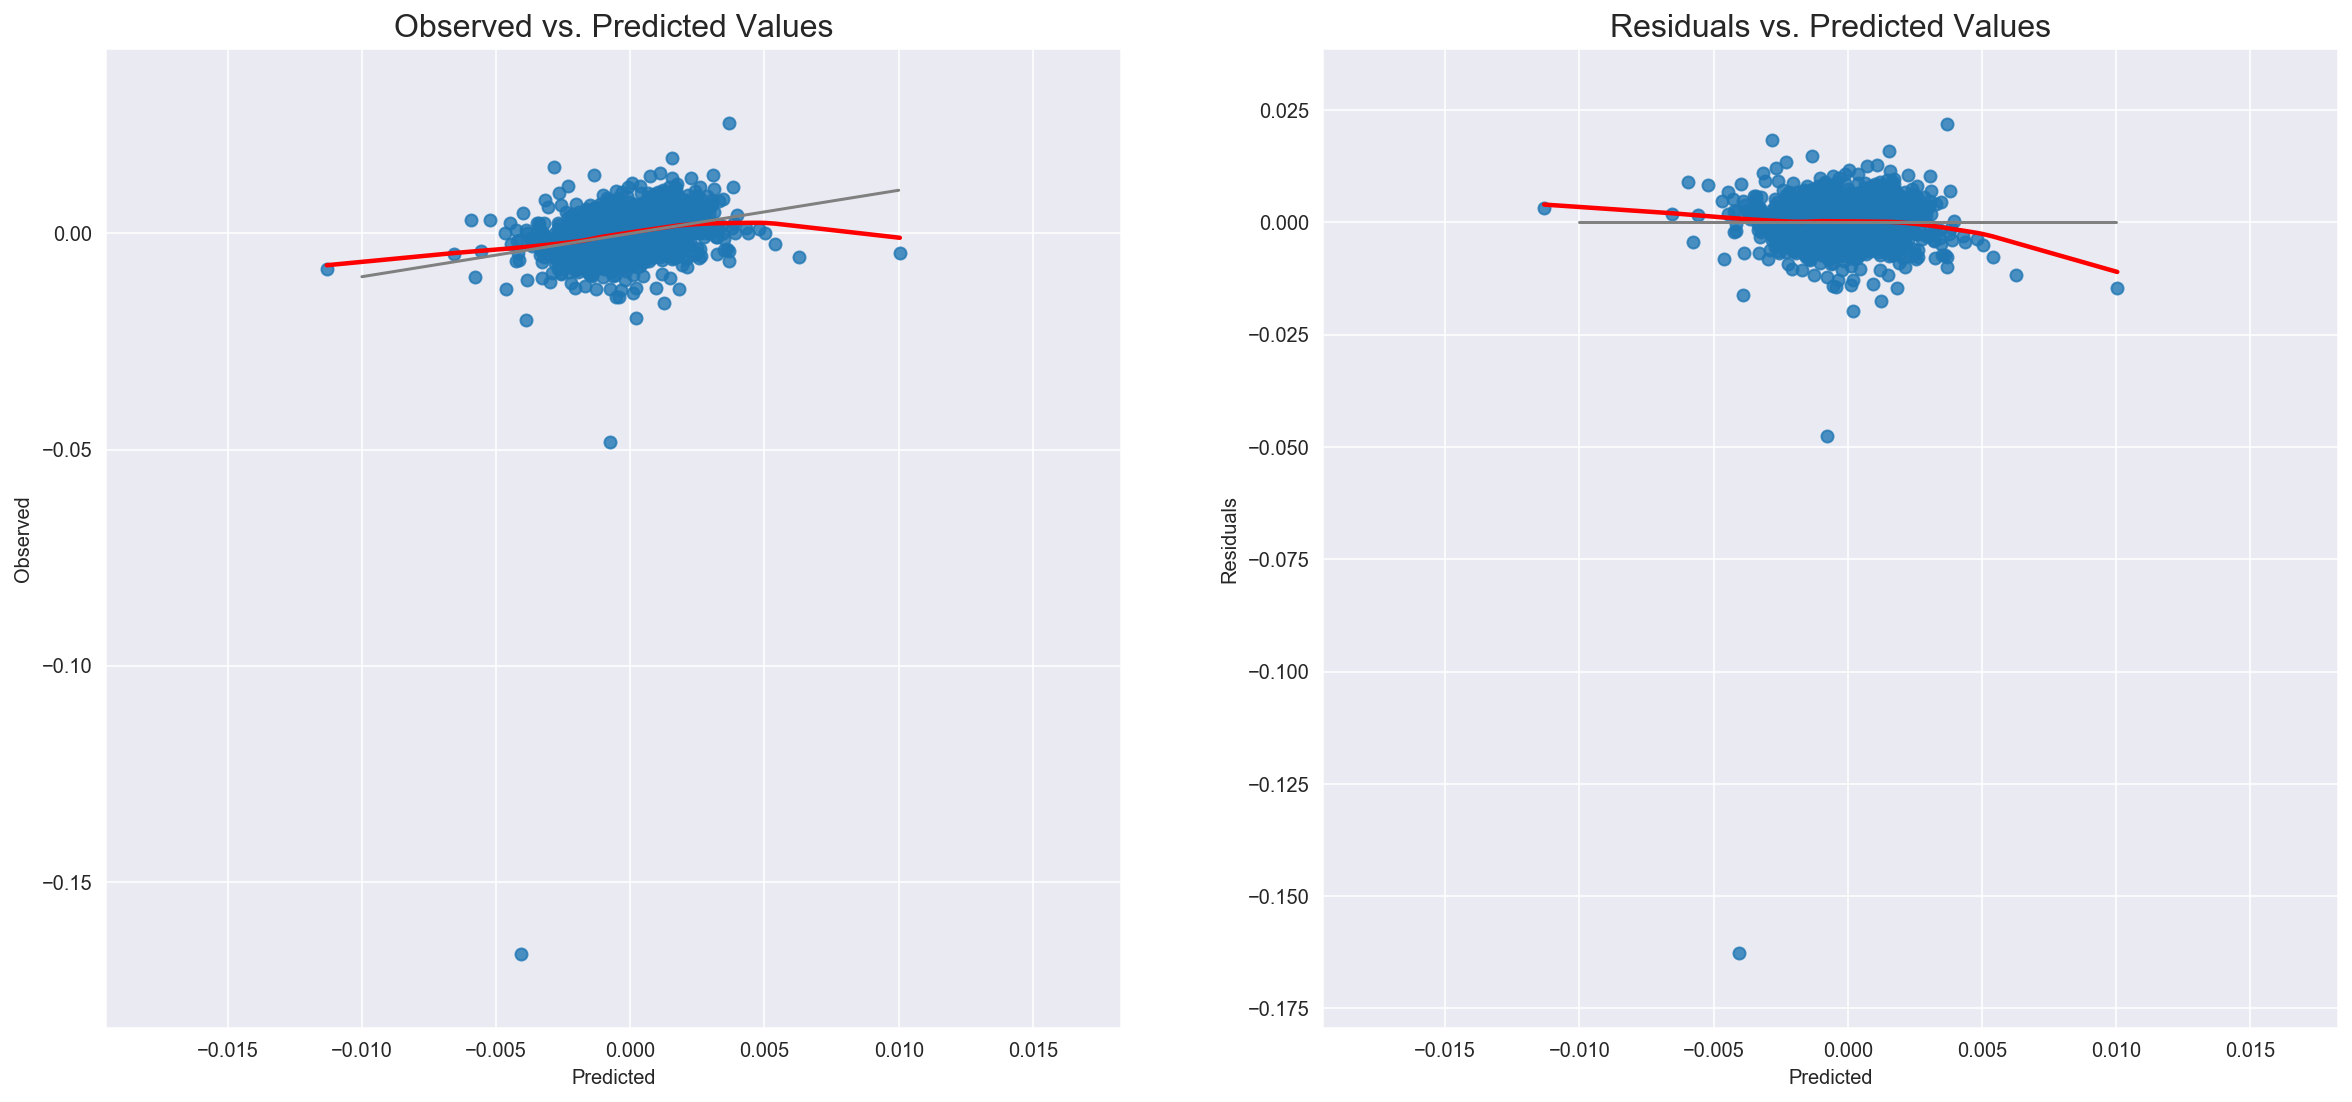

In [23]:
linearity_test(result_m, y_m) 

Linearity is not really satisfied since there is clearly a bowl pattern indicating the model is making unusual large/small predictions. If linearity exists, the left plot should be scattered around diagnal line, and the right plot should be scattered around a horizontal line.

Potential solutions:
- linear transformations to dependent/independent variables
- adding extra features which are a transformation of the already used ones (for example squared version)
- adding features that were not considered before

### IV.B) Strict exogeneity
- The distribution of error terms has zero mean and 
- doesn’t depend on the independent variables X. i.e. there must be no relationship between the X and the error term.

In [24]:
print(f"mean of residuals = {resid_m.mean()}")

mean of residuals = -2.0738910796235802e-19


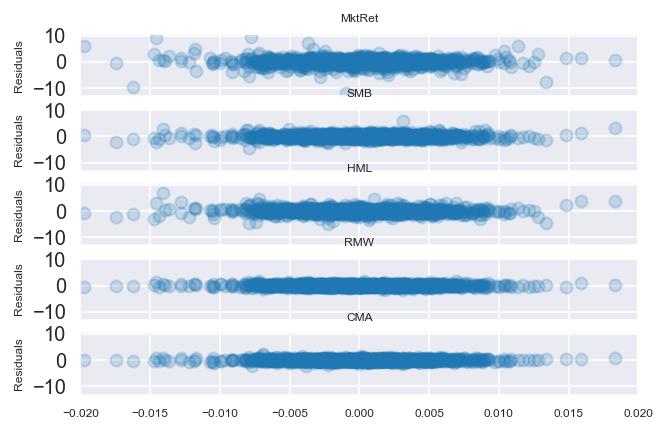

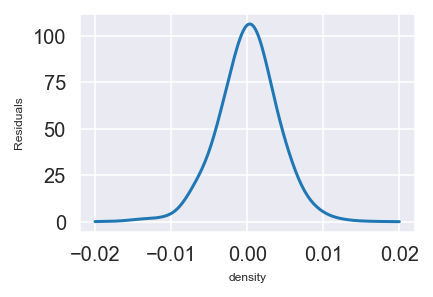

In [98]:
plt.figure(figsize=(5,4))
ax1 = plt.subplot(611)
plt.scatter(resid_m, FF5_m_2[FF5_m_2.columns[0]],  alpha=0.2)
plt.title(FF5_m_2.columns[0], fontsize=6)
plt.ylabel("Residuals", fontsize=6)
plt.xlim(-0.02, 0.02)
plt.setp(ax1.get_xticklabels(), visible=False)

# share x only
ax2 = plt.subplot(612, sharex = ax1, sharey=ax1)
plt.scatter(resid_m, FF5_m_2[FF5_m_2.columns[1]],  alpha=0.2)
plt.title(FF5_m_2.columns[1], fontsize=6)
plt.ylabel("Residuals", fontsize=6)
# make these tick labels invisible
plt.setp(ax2.get_xticklabels(), visible=False)

ax3 = plt.subplot(613,  sharex = ax1,sharey=ax1)
plt.scatter(resid_m, FF5_m_2[FF5_m_2.columns[2]], alpha=0.2)
plt.title(FF5_m_2.columns[2], fontsize=6)
plt.ylabel("Residuals", fontsize=6)
plt.setp(ax3.get_xticklabels(), visible=False)

ax4 = plt.subplot(614,  sharex = ax1,sharey=ax1)
plt.scatter(resid_m, FF5_m_2[FF5_m_2.columns[3]],  alpha=0.2)
plt.title(FF5_m_2.columns[3], fontsize=6)
plt.ylabel("Residuals", fontsize=6)
plt.setp(ax4.get_xticklabels(), visible=False)

ax5 = plt.subplot(615, sharex = ax1,sharey=ax1)
plt.scatter(resid_m, FF5_m_2[FF5_m_2.columns[4]],  alpha=0.2)
plt.title(FF5_m_2.columns[4], fontsize=6)
plt.ylabel("Residuals", fontsize=6)
plt.setp(ax5.get_xticklabels(), fontsize=6)
plt.show()

from scipy.stats import gaussian_kde
plt.figure(figsize=(3,2))
density = gaussian_kde(resid_m)
xs = np.linspace(-0.02,0.02,200)
density.covariance_factor = lambda : .25
density._compute_covariance()
plt.ylabel("Residuals", fontsize=6)
plt.xlabel("density", fontsize=6)
plt.plot(xs,density(xs))
plt.show()

In [26]:
from scipy.stats.stats import pearsonr
# Pearson correlation coefficient
def pearson_corr_test(X_with_cons, model_resid):
    print('Performing Pearson Correlation Test ...')
    for column in X_with_cons.columns[1:]:
        corr_test = pearsonr(X_with_cons[column], model_resid)
        print(f'{column} \n correlation: {corr_test[0]} \n p-value: {corr_test[1]}')
        if corr_test[1] < 0.05:
            print(" Rej null, conclude correlated.\n")
        else:
            print(' Fail to rej null, conclude non-correlated\n')

In [27]:
pearson_corr_test(X_m, resid_m)

Performing Pearson Correlation Test ...
MktRet 
 correlation: 8.168140055442918e-17 
 p-value: 1.0000000000007492
 Fail to rej null, conclude non-correlated

SMB 
 correlation: -2.833601944615455e-17 
 p-value: 1.0000000000007598
 Fail to rej null, conclude non-correlated

HML 
 correlation: -4.609831804775589e-18 
 p-value: 1.0000000000007598
 Fail to rej null, conclude non-correlated

RMW 
 correlation: 1.9622641582706945e-16 
 p-value: 1.0000000000008598
 Fail to rej null, conclude non-correlated

CMA 
 correlation: -3.5533652968590037e-17 
 p-value: 1.0000000000007598
 Fail to rej null, conclude non-correlated



For both graphical and test approaches, we see that Strict exogeneity is satisfied. Residual mean is about zero, and the correlation between residuals and regressors are really small to zero. 

### IV.C) No Multicollinearity
There should be no linear relationship between the independent variables. 

- Looking at bivariate correlation. corr > 0.8 is an indicator of multicollinearity

Notes:

Here are more potential indicators of multicollinearity:

1. Very high standard errors for regression coefficients
When standard errors are orders of magnitude higher than their coefficients, that’s an indicator.

2. The overall model is significant, but none of the coefficients are
Remember that a p-value for a coefficient tests whether the unique effect of that predictor on Y
is zero. If all predictors overlap in what they measure, there is little unique effect, even if 
the predictors as a group have an effect on Y.

3. Large changes in coefficients when adding predictors
If the predictors are completely independent of each other, their coefficients won’t change at 
all when you add or remove one. But the more they overlap, the more drastically their 
coefficients will change.

4. Coefficients have signs opposite what you’d expect from theory
Be careful here as you don’t want to disregard an unexpected finding as problematic. Not all 
effects opposite theory indicate a problem with the model. That said, it could be 
multicollinearity and warrants taking a second look at other indicators.

5. Coefficients on different samples are wildly different
If you have a large enough sample, split the sample in half and run the model separately on 
each half. Wildly different coefficients in the two models could be a sign of multicollinearity.

6. High Variance Inflation Factor (VIF) and Low Tolerance
These two useful statistics are reciprocals of each other. So either a high VIF or a low 
tolerance is indicative of multicollinearity. VIF is a direct measure of how much the variance 
of the coefficient (ie. its standard error) is being inflated due to multicollinearity. the square root of a given variable’s VIF shows how much larger the standard error is, compared with what it would be if that predictor were uncorrelated with the other features in the model. If no features are correlated, then all values for VIF will be 1. To deal with multicollinearity we should iteratively remove features with high values of VIF. A rule of thumb for removal could be VIF larger than 10 (5 is also common). Another possible solution is to use PCA to reduce features to a smaller set of uncorrelated components.

7. High Condition Indices
Condition indices are a bit strange.  The basic idea is to run a Principal Components Analysis 
on all predictors. If they have a lot of shared information, the first Principal Component 
will be much higher than the last. Their ratio, the Condition Index, will be high if 
multicollinearity is present.

In [28]:
# bivariate correlation
FF5_m_2.corr()

,MktRet,SMB,HML,RMW,CMA
MktRet,1.000000,0.161263,0.120142,-0.050357,-0.192268
SMB,0.161263,1.000000,0.354128,-0.121167,0.074147
HML,0.120142,0.354128,1.000000,0.234338,0.515556
RMW,-0.050357,-0.121167,0.234338,1.000000,0.224786
CMA,-0.192268,0.074147,0.515556,0.224786,1.000000


In [29]:
# VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
def VIF_test(X_constant_added):
    vif = [variance_inflation_factor(X_constant_added.values, i) for i in range(X_constant_added.shape[1])]
    VIF_df = pd.DataFrame({'vif': vif}, index=X_constant_added.columns).T
    VIF_df = VIF_df[VIF_df.columns[1:]]
    return VIF_df
VIF_test(X_m)

,MktRet,SMB,HML,RMW,CMA
vif,1.124618,1.22791,1.730358,1.125919,1.522737


No Multicollinearity is satisfied. (Indicator of strong Multicollinearity: corr > 0.8, VIF >5) Luckily enough since in reality, when we have so many factors, they are likely correlated with each other. Multicollinearity is common. What if we detect the multicollinearity in pratice? 

Potential Solution:
- One it to iteratively remove features with high values of VIF. A rule of thumb for removal could be VIF larger than 10 (5 is also common). 
- Another possible solution is to use PCA/or other dimension reduction techniques to reduce features to a smaller set of uncorrelated components.

### IV.D) Spherical error variance
There is homoscedasticity and no autocorrelation.

- The error terms in the regression should all have the same variance.
    (Heteroscedastic errors: error variance is not constant, i.e. depend on Xs.)
    - scatter plot of residuals
    - Also use two statistical tests: **Breusch-Pagan** and **Goldfeld-Quandt**. 
        - In both of them, the null hypothesis **H0** assumes homoscedasticity
        - p-value <0.05 : reject the null, conclude heteroscedasticity.
- The error terms of different observations should not be correlated with each other, i.e.error terms should be IID (Independent and Identically Distributed).
    - When we have time series data, then the regression is likely to suffer from autocorrelation because data next year will most likely be dependent on data this year. Hence, error terms in different observations will surely be correlated with each other.
    - Check for autocorrelation by viewing the residual time series plot, or acf to visualize autocorrelation if any. 
    - If autocorrelation is present in the model, we can try taking lags of independent variables to correct for the trend component. If we do not correct for autocorrelation, then OLS estimates won’t be BLUE, and they won’t be reliable enough.

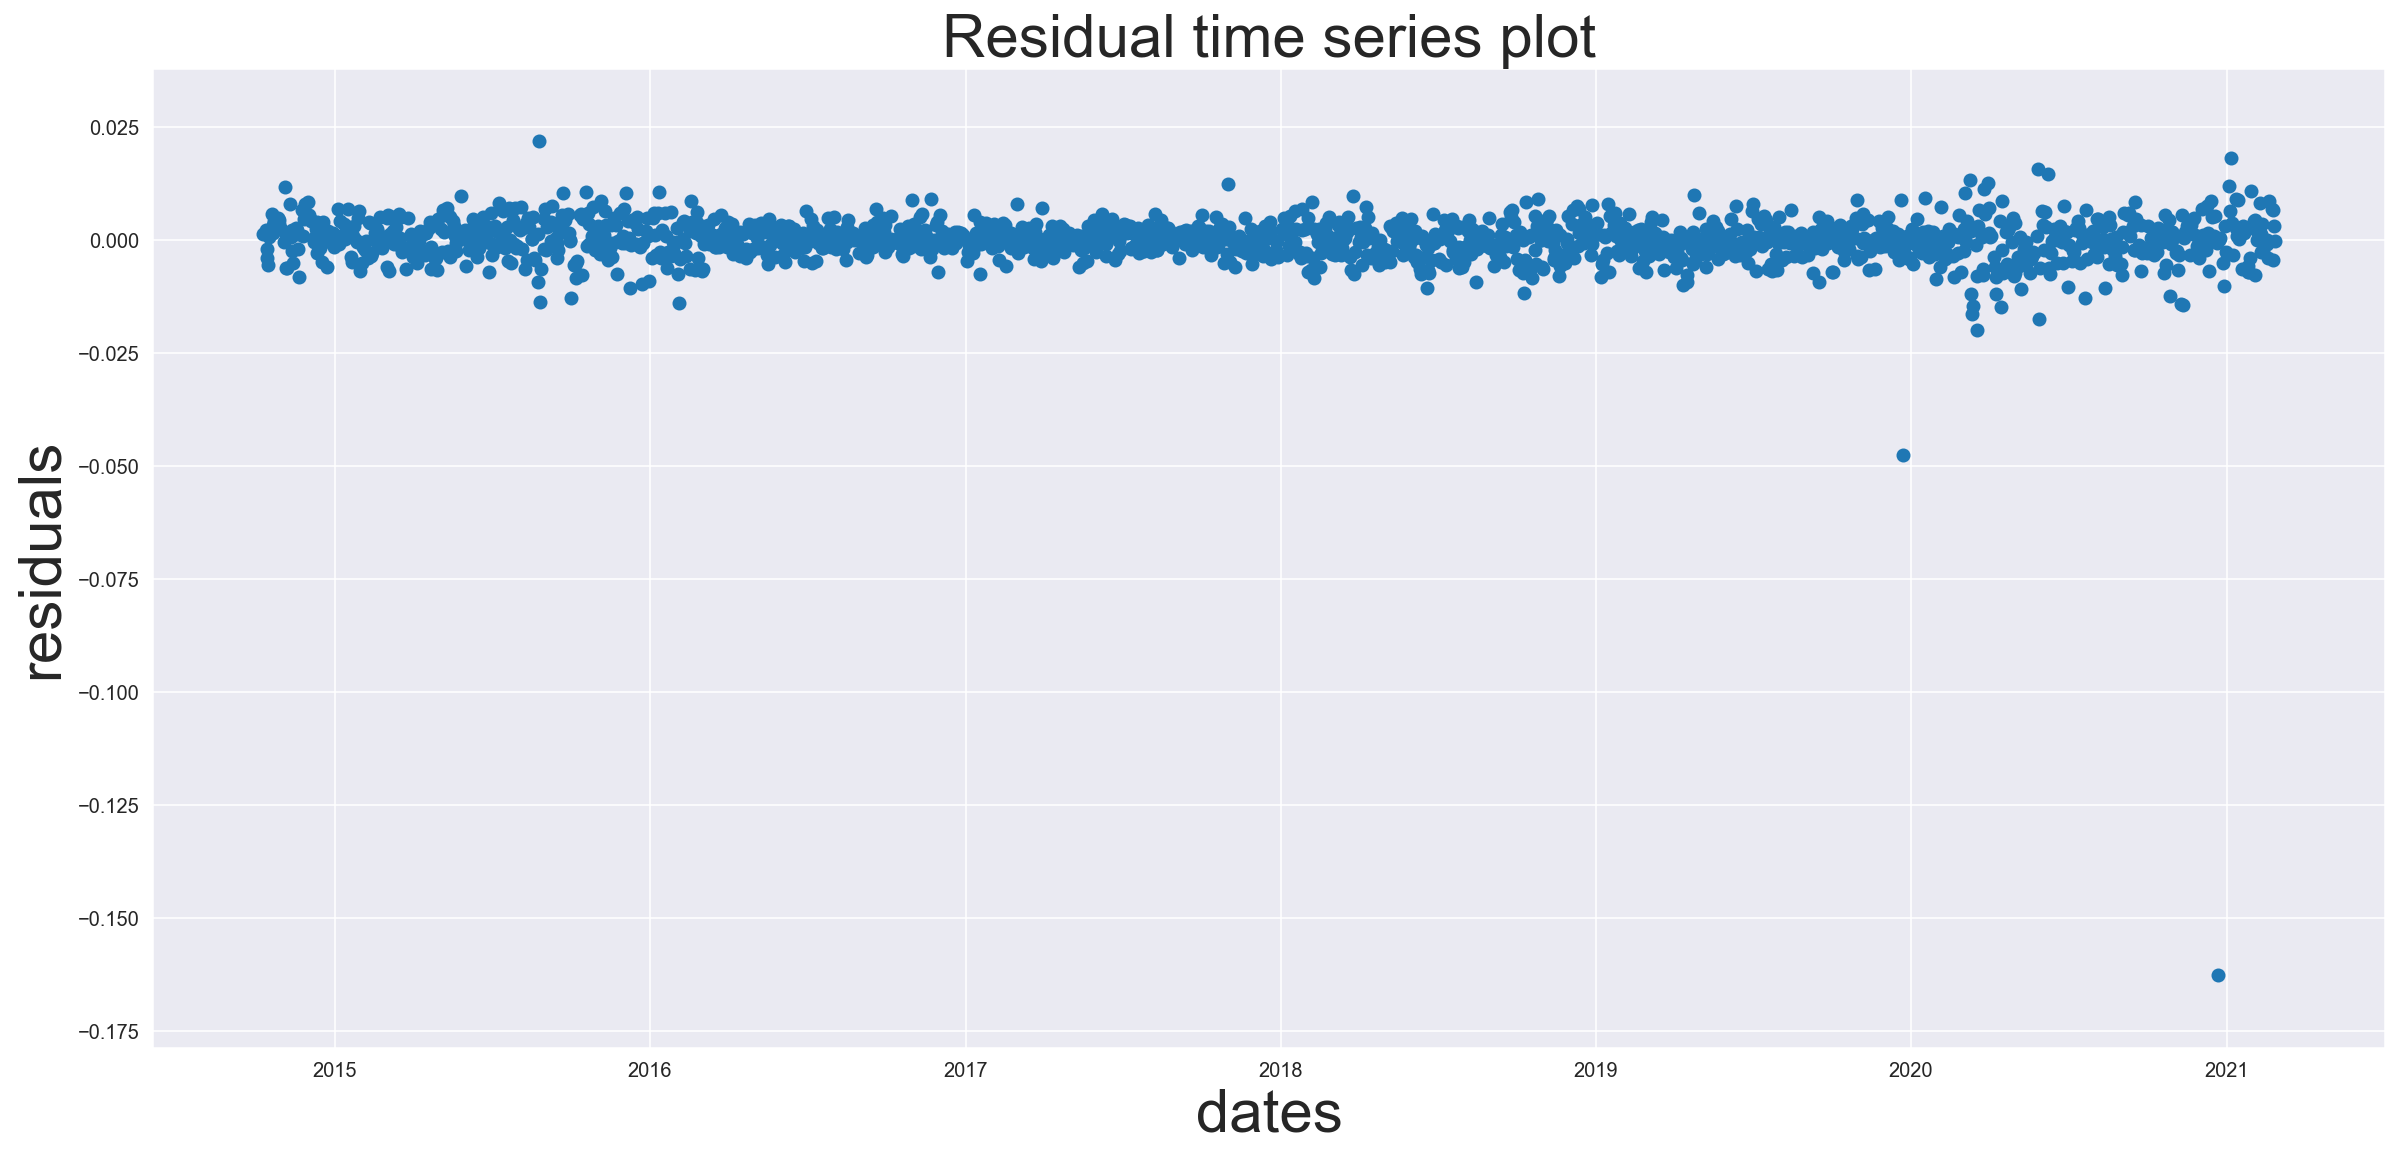

In [30]:
# to see constant variance of error terms
plt.scatter(y = resid_m, x = FF5_m_2.index)
plt.title('Residual time series plot', fontsize = 30)
plt.ylabel('residuals', fontsize = 30)
plt.xlabel('dates', fontsize = 30)
plt.show()

Looks bad, the variance is not constant over time. For example, higher variance around 2015 and 2020.

In [31]:
def homoscedasticity_test(model):
    ''' Testing the homoscedasticity of residuals in a linear regression model.
    It plots residuals and standardized residuals vs. fitted values and runs Breusch-Pagan and Goldfeld-Quandt tests.
    
    Args
    ----------
    model: fitted OLS model from statsmodels
    '''
    fitted_vals = model.predict()
    resids = model.resid
    resids_standardized = model.get_influence().resid_studentized_internal

    fig, ax = plt.subplots(1,2)

    sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[0], line_kws={'color': 'red'})
    ax[0].set_title('Residuals vs Fitted', fontsize=16)
    ax[0].set(xlabel='Fitted Values', ylabel='Residuals')

    sns.regplot(x=fitted_vals, y=np.sqrt(np.abs(resids_standardized)), lowess=True, ax=ax[1], line_kws={'color': 'red'})
    ax[1].set_title('Standardized Residuals vd Fitted', fontsize=16)
    ax[1].set(xlabel='Fitted Values', ylabel='sqrt(abs(Residuals))')

    bp_test = pd.DataFrame(sms.het_breuschpagan(resids, model.model.exog), 
                           columns=['value'],
                           index=['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value'])

    gq_test = pd.DataFrame(sms.het_goldfeldquandt(resids, model.model.exog)[:-1],
                           columns=['value'],
                           index=['F statistic', 'p-value'])
    def conclude(score):
        if score < 0.05:
            print('Reject Null, conclude heteroscedasticity')
        else:
            print('Fail to Reject Null, conclude homoscedasticity')
            
    print('\n---- Breusch-Pagan test ----')
    print(bp_test)
    conclude(bp_test.loc['p-value'].values)
    print('\n---- Goldfeld-Quandt test ----')
    print(gq_test)
    conclude(gq_test.loc['p-value'].values)
    print('\n---- Residuals plots ----')


---- Breusch-Pagan test ----
                                   value
Lagrange multiplier statistic  11.324054
p-value                         0.045320
f-value                         2.272372
f p-value                       0.045175
Reject Null, conclude heteroscedasticity

---- Goldfeld-Quandt test ----
                    value
F statistic  4.480931e+00
p-value      9.346596e-92
Reject Null, conclude heteroscedasticity

---- Residuals plots ----


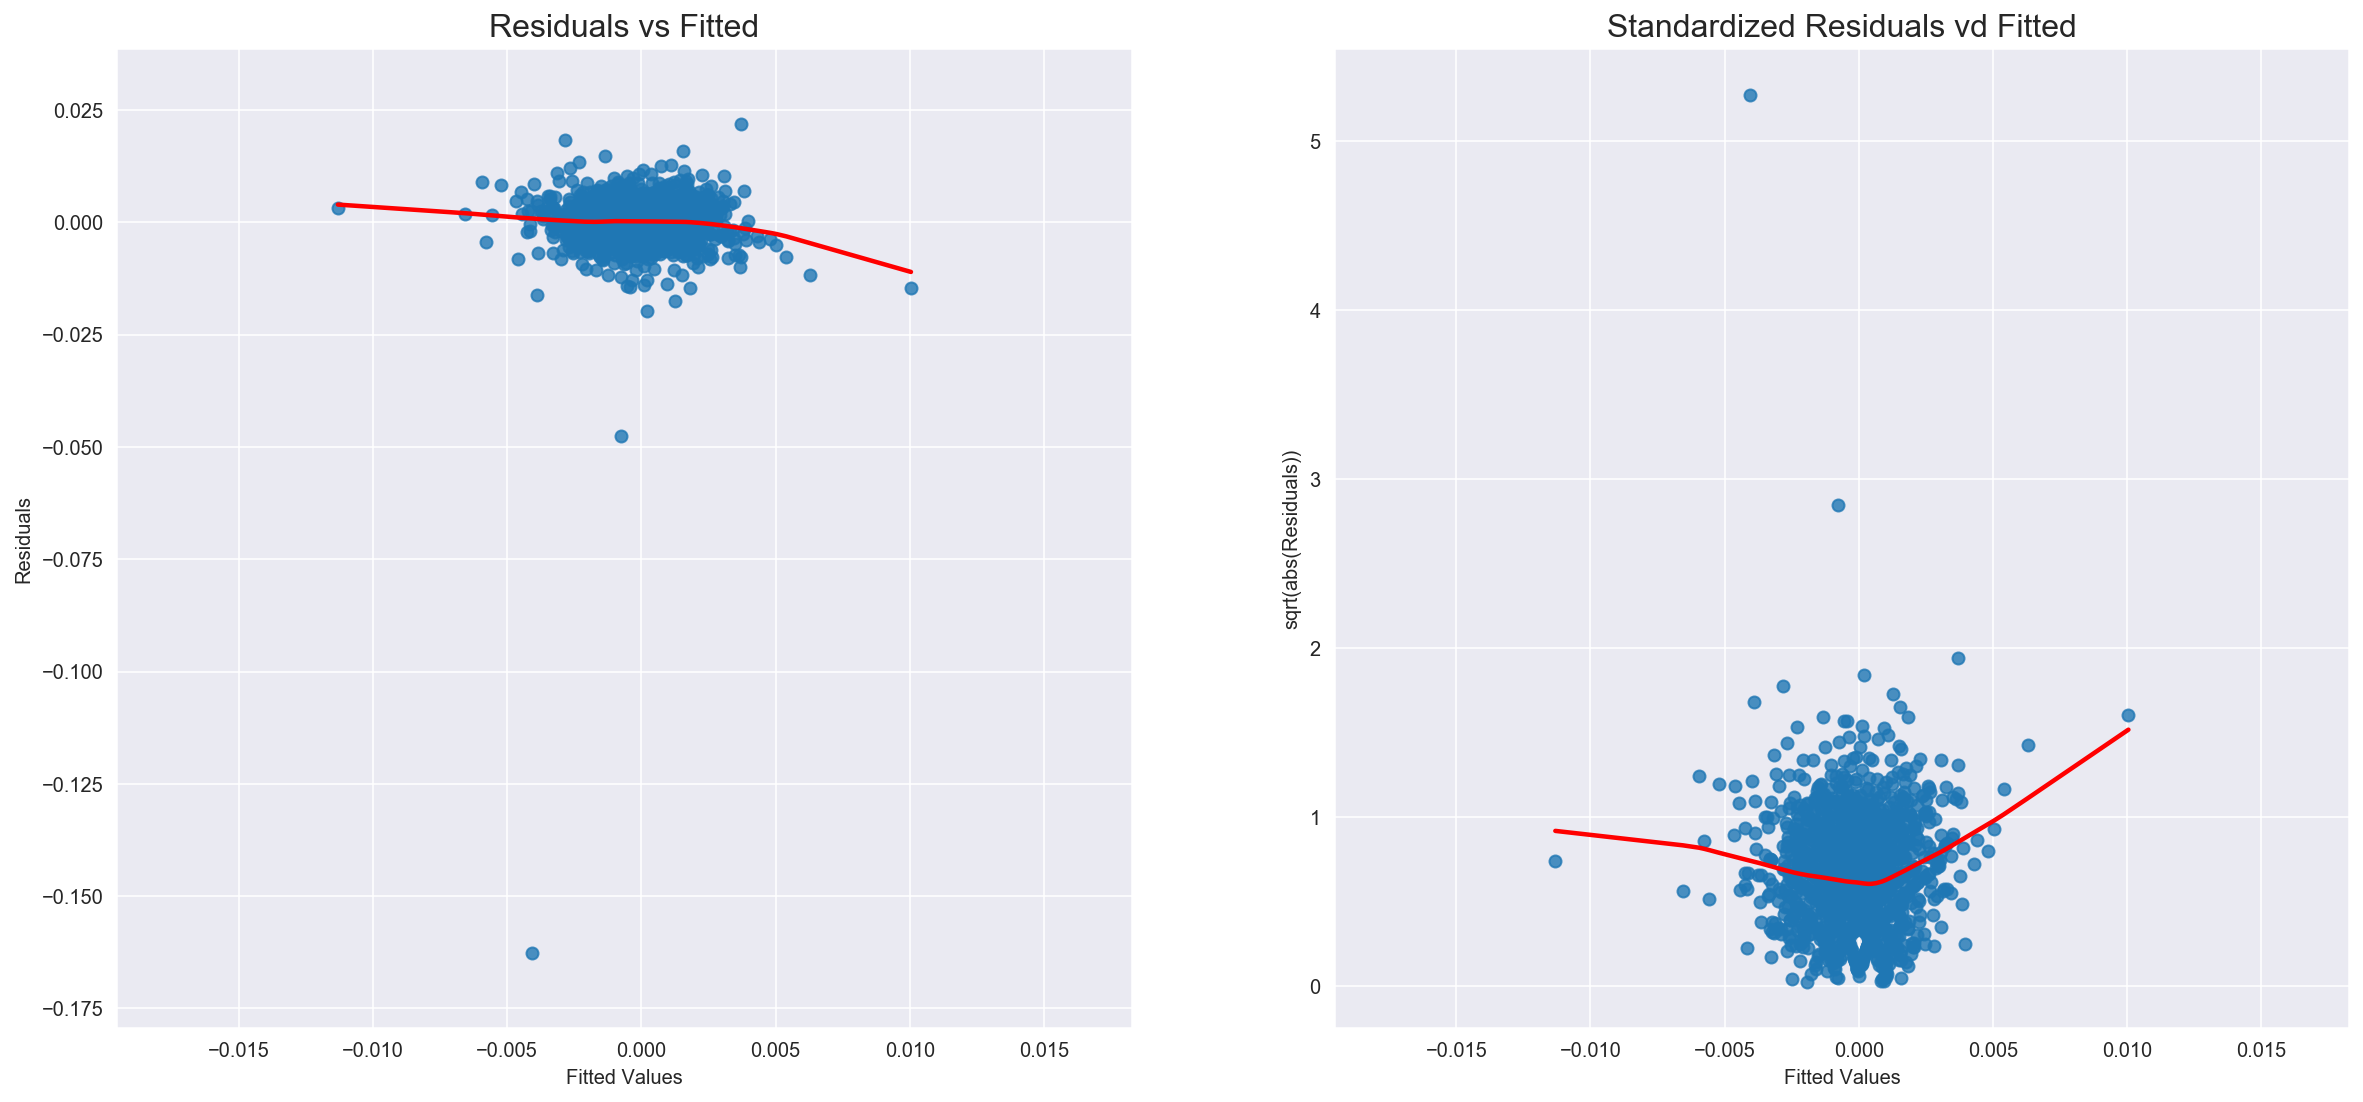

In [32]:
homoscedasticity_test(result_m)

Both tests indicate that there is a significant evidence of heterodasticity and hence residuals won't be IID as a result. Let's furtherly test the autocorrelation.

In [100]:
# check autocorrelation(IID) of error terms
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.stattools import durbin_watson
def autocorrelation_test(rds):
    durbinWatson = durbin_watson(rds)
    print('Durbin-Watson acf test:', durbinWatson)
    if durbinWatson < 2-0.05:
        print('Signs of positive autocorrelation', '\n')
        print('Assumption not satisfied')
    elif durbinWatson > 2+0.05:
        print('Signs of negative autocorrelation', '\n')
        print('Assumption not satisfied')
    else:
        print('No autocorrelation', '\n')
        print('Assumption satisfied')
    plot_acf(rds, lags = 15)
    plt.show()

Durbin-Watson acf test: 1.9623593087965796
No autocorrelation 

Assumption satisfied


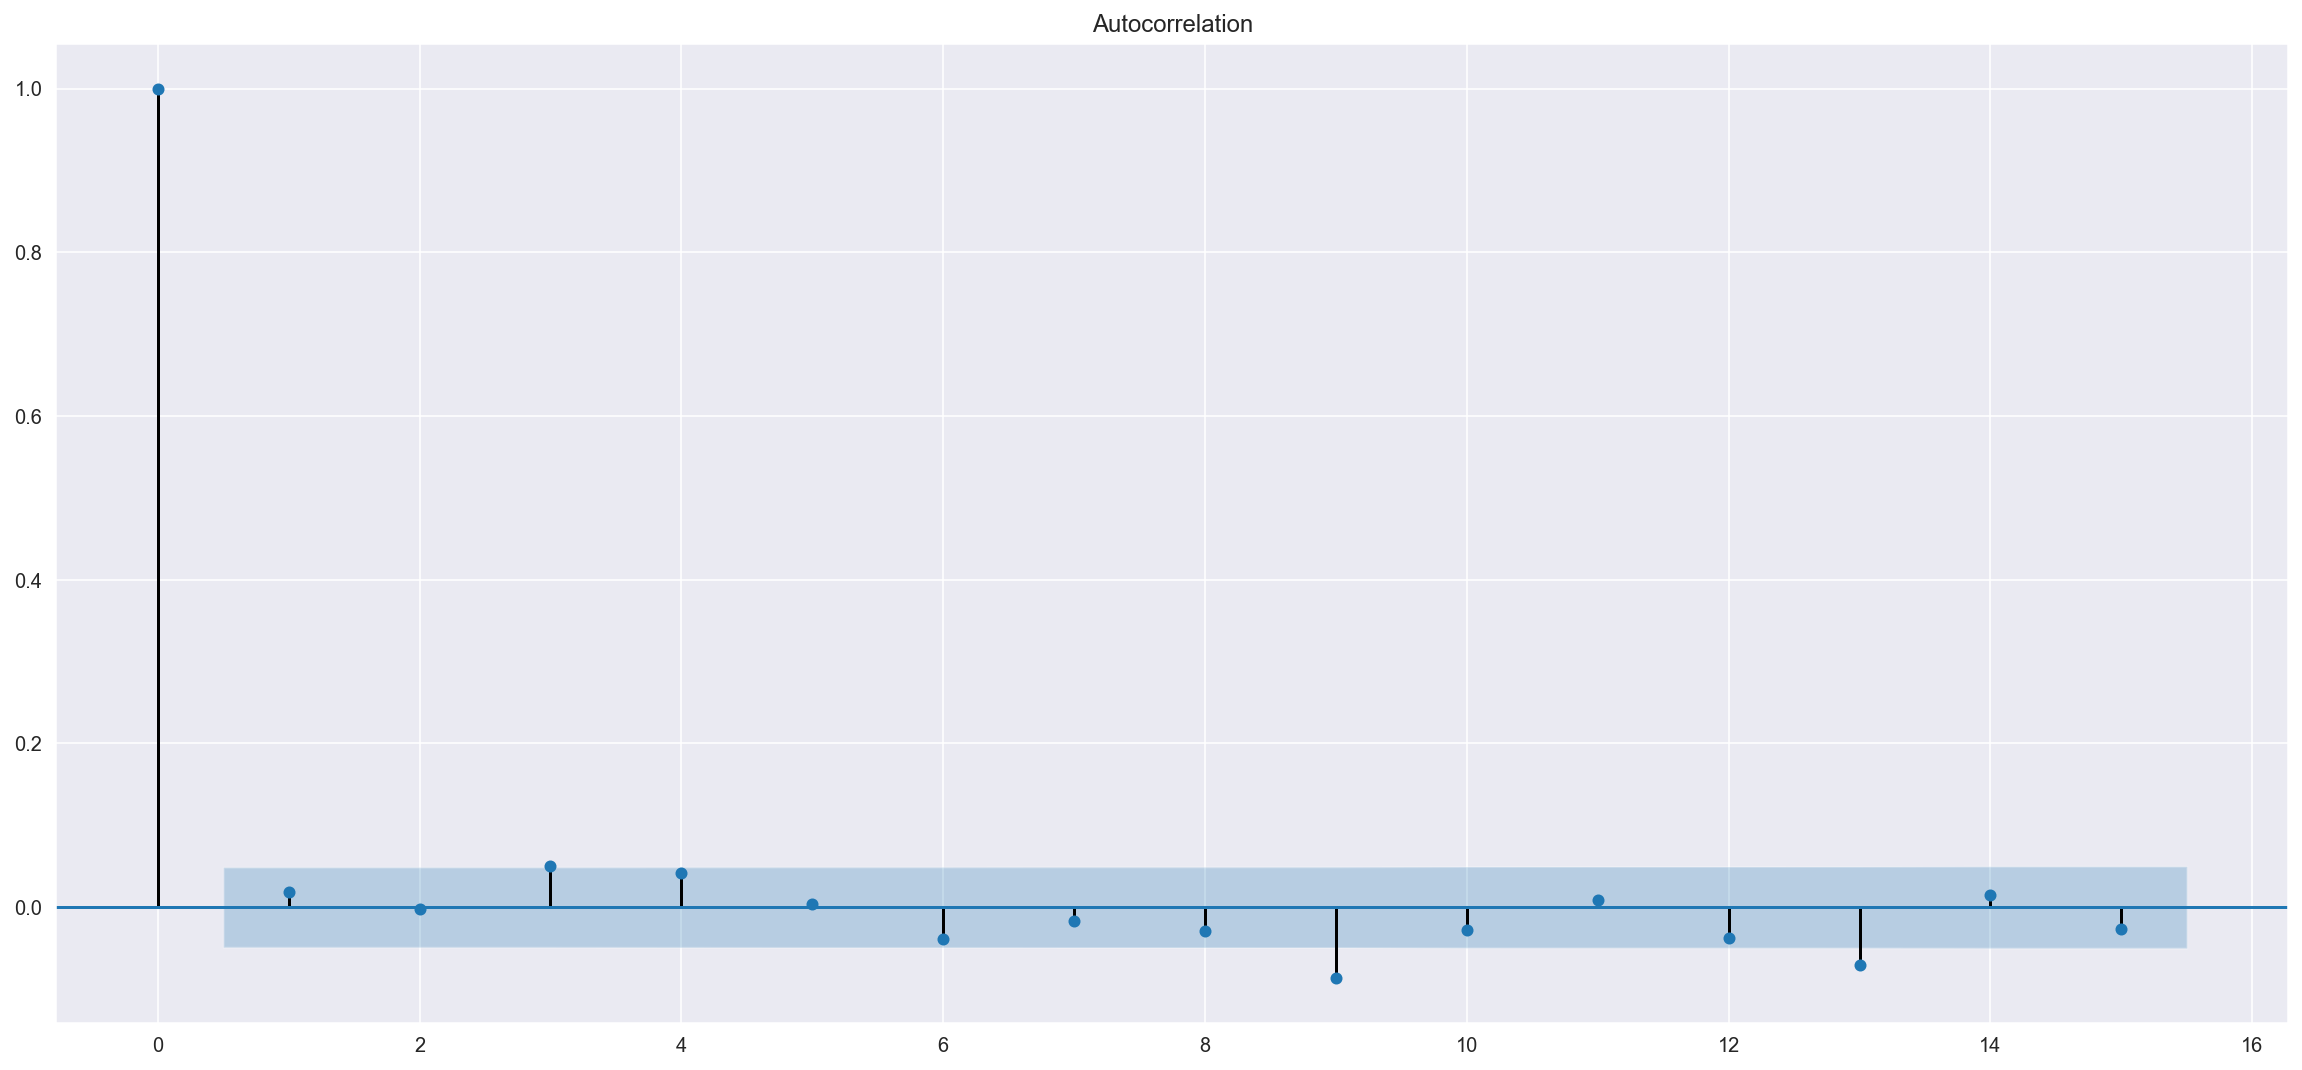

In [101]:
autocorrelation_test(resid_m)

Spherical error variance is not satisfied since we see a non-constant residual variance over time. There is no strong evidence of autocorrelation of residuals though.

Potential solutions:
- heteroscedasticity: 
    - log transformation of the dependent variable
    - in case of time series, deflating a series if it concerns monetary value
    - using ARCH (auto-regressive conditional heteroscedasticity) models to model the error variance. An example might be stock market, where data can exhibit periods of increased or decreased volatility over time (volatility clustering)
- autocorrelation:
    - in case of minor positive autocorrelation, there might be some room for fine-tuning the model, for example, adding lags of the dependent/independent variables
    - some seasonal components might not be captured by the model, account for them using dummy variables or seasonally adjust the variables
    - if DW < 1 it might indicate a possible problem in model specification, consider stationarizing time-series variables by differencing, logging, and/or deflating (in case of monetary values)
    - in case of significant negative correlation, some of the variables might have been overdifferenced
    - use Generalized Least Squares
    - include a linear (trend) term in case of a consistent increasing/decreasing pattern in the residuals

### IV.E) Normality:
Note that residual iid and normality if for finite sample inference. Without these two assumptions, the OLS estimates are still BLUE. However, the finite sample inference results, such as the standard error, t-statistics and F-stats, would not be relible. Also, confidence intervals are either too wide or too narrow. 

Also, note that in OLS, error terms are desired to be normal, not the dependent nor response terms.

In [35]:
print(f'residual mean: {resid_m.mean()}')
print(f'residual std: {resid_m.std()}')
s = pd.DataFrame(np.random.normal(resid_m.mean(), resid_m.std(), len(resid_m)))
print(f'skewness: \n   residual: {resid_m.skew()} \n   normal: {s[0].skew()}')
print(f'kurtosis: \n   residual: {resid_m.kurtosis()} \n   normal: {s[0].kurtosis()}')

residual mean: -2.0738910796235802e-19
residual std: 0.005854370954103162
skewness: 
   residual: -13.71075168580616 
   normal: -0.05226078344177123
kurtosis: 
   residual: 373.2293608076401 
   normal: -0.13294519045441655


Text(0.5, 1.0, 'Q-Q plot')

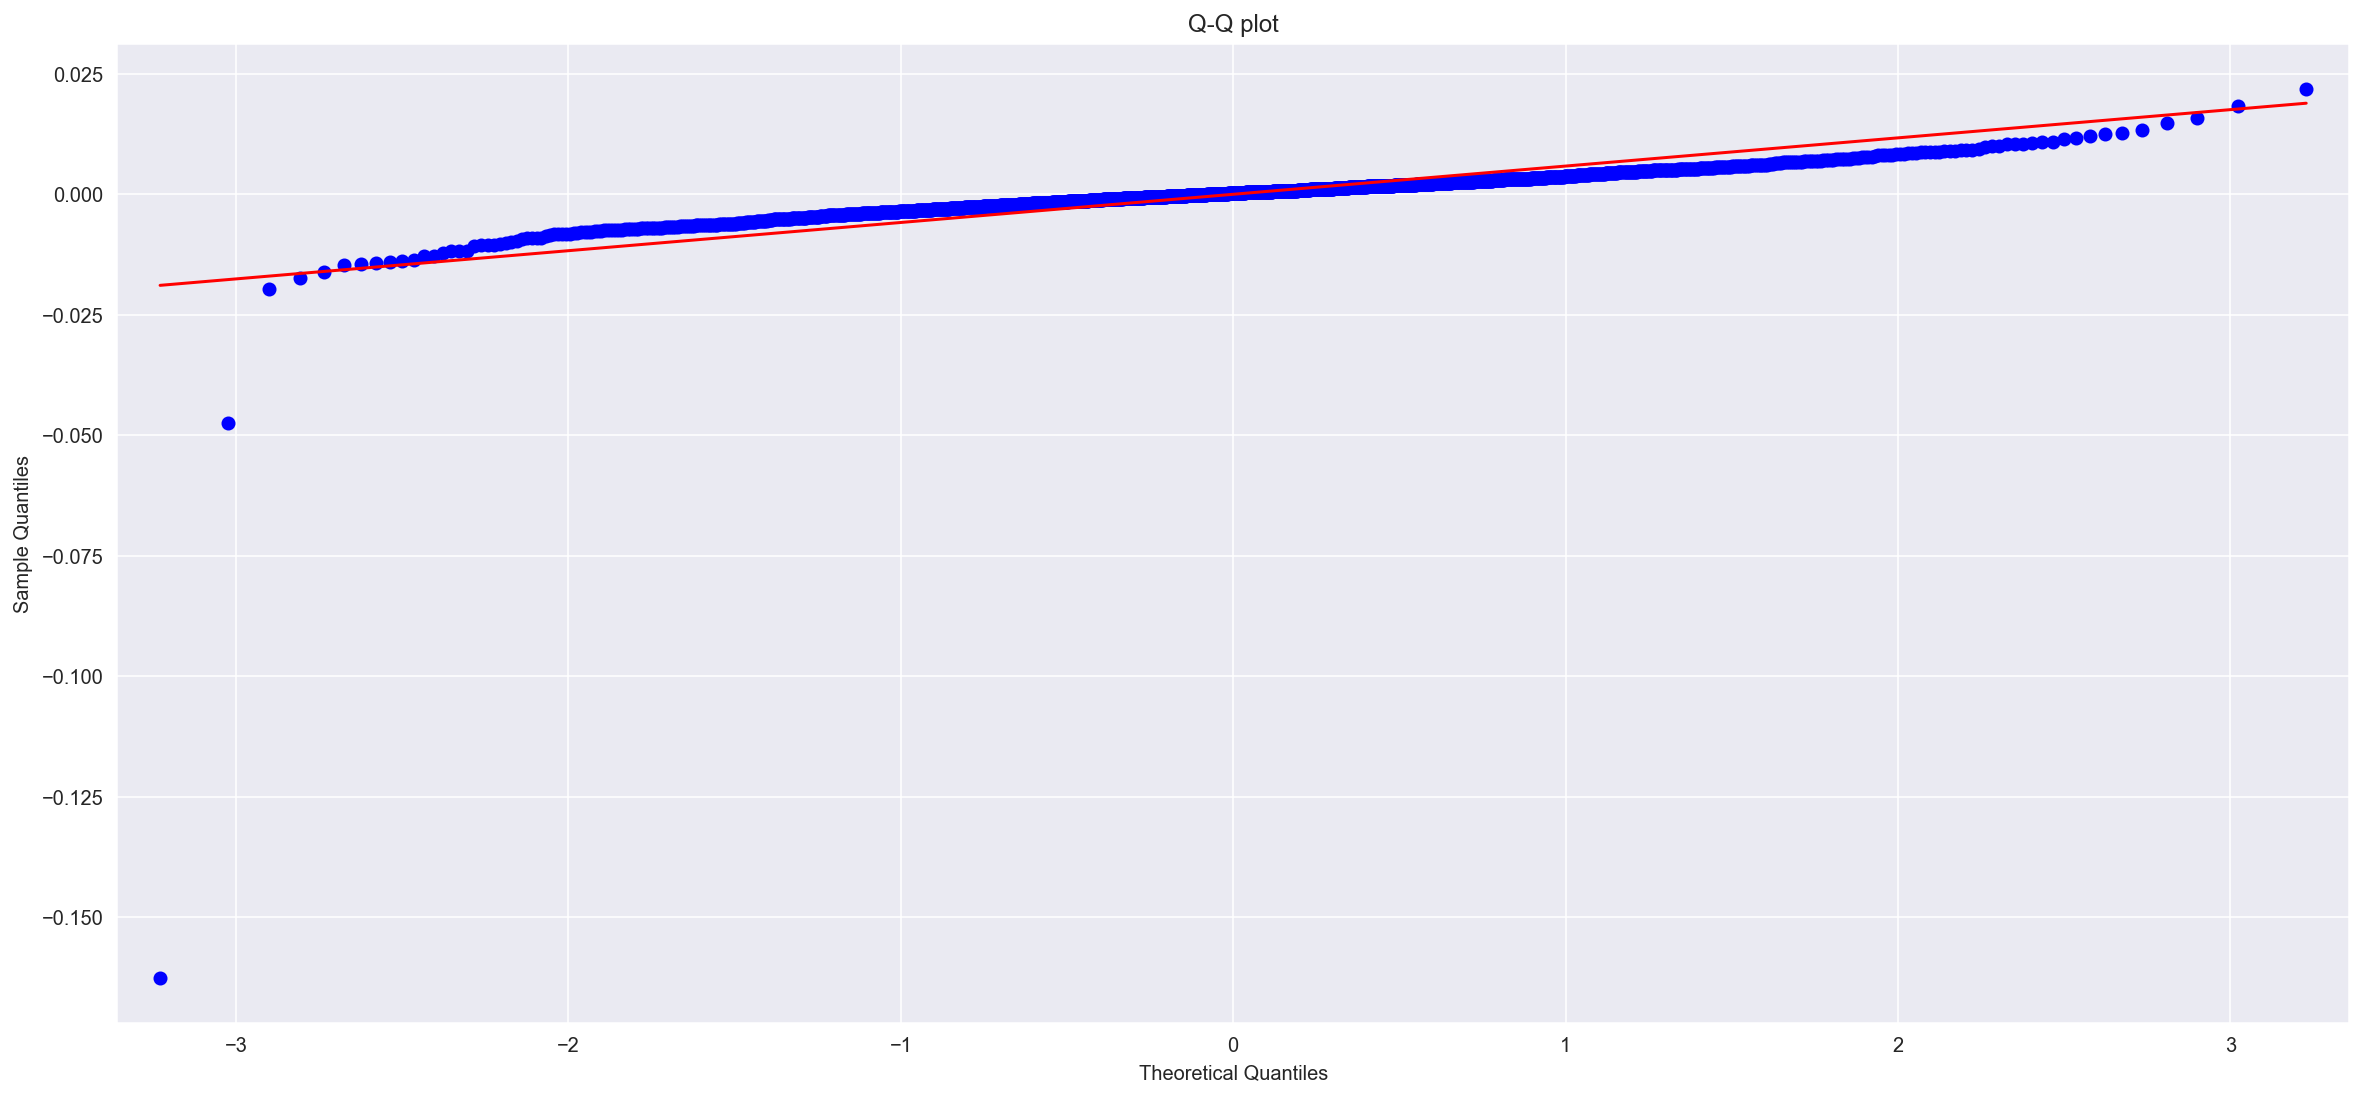

In [102]:
sm.ProbPlot(resid_m).qqplot(line='s')
plt.title('Q-Q plot')

In [36]:
from statsmodels.stats.diagnostic import normal_ad
def normality_test(series):
    pva = normal_ad(series)[1]
    if pva<0.05:
        print('Non-normal')
    else:
        print('Normal')
    series.hist()
    series.plot(kind='kde')
    plt.show()

Non-normal


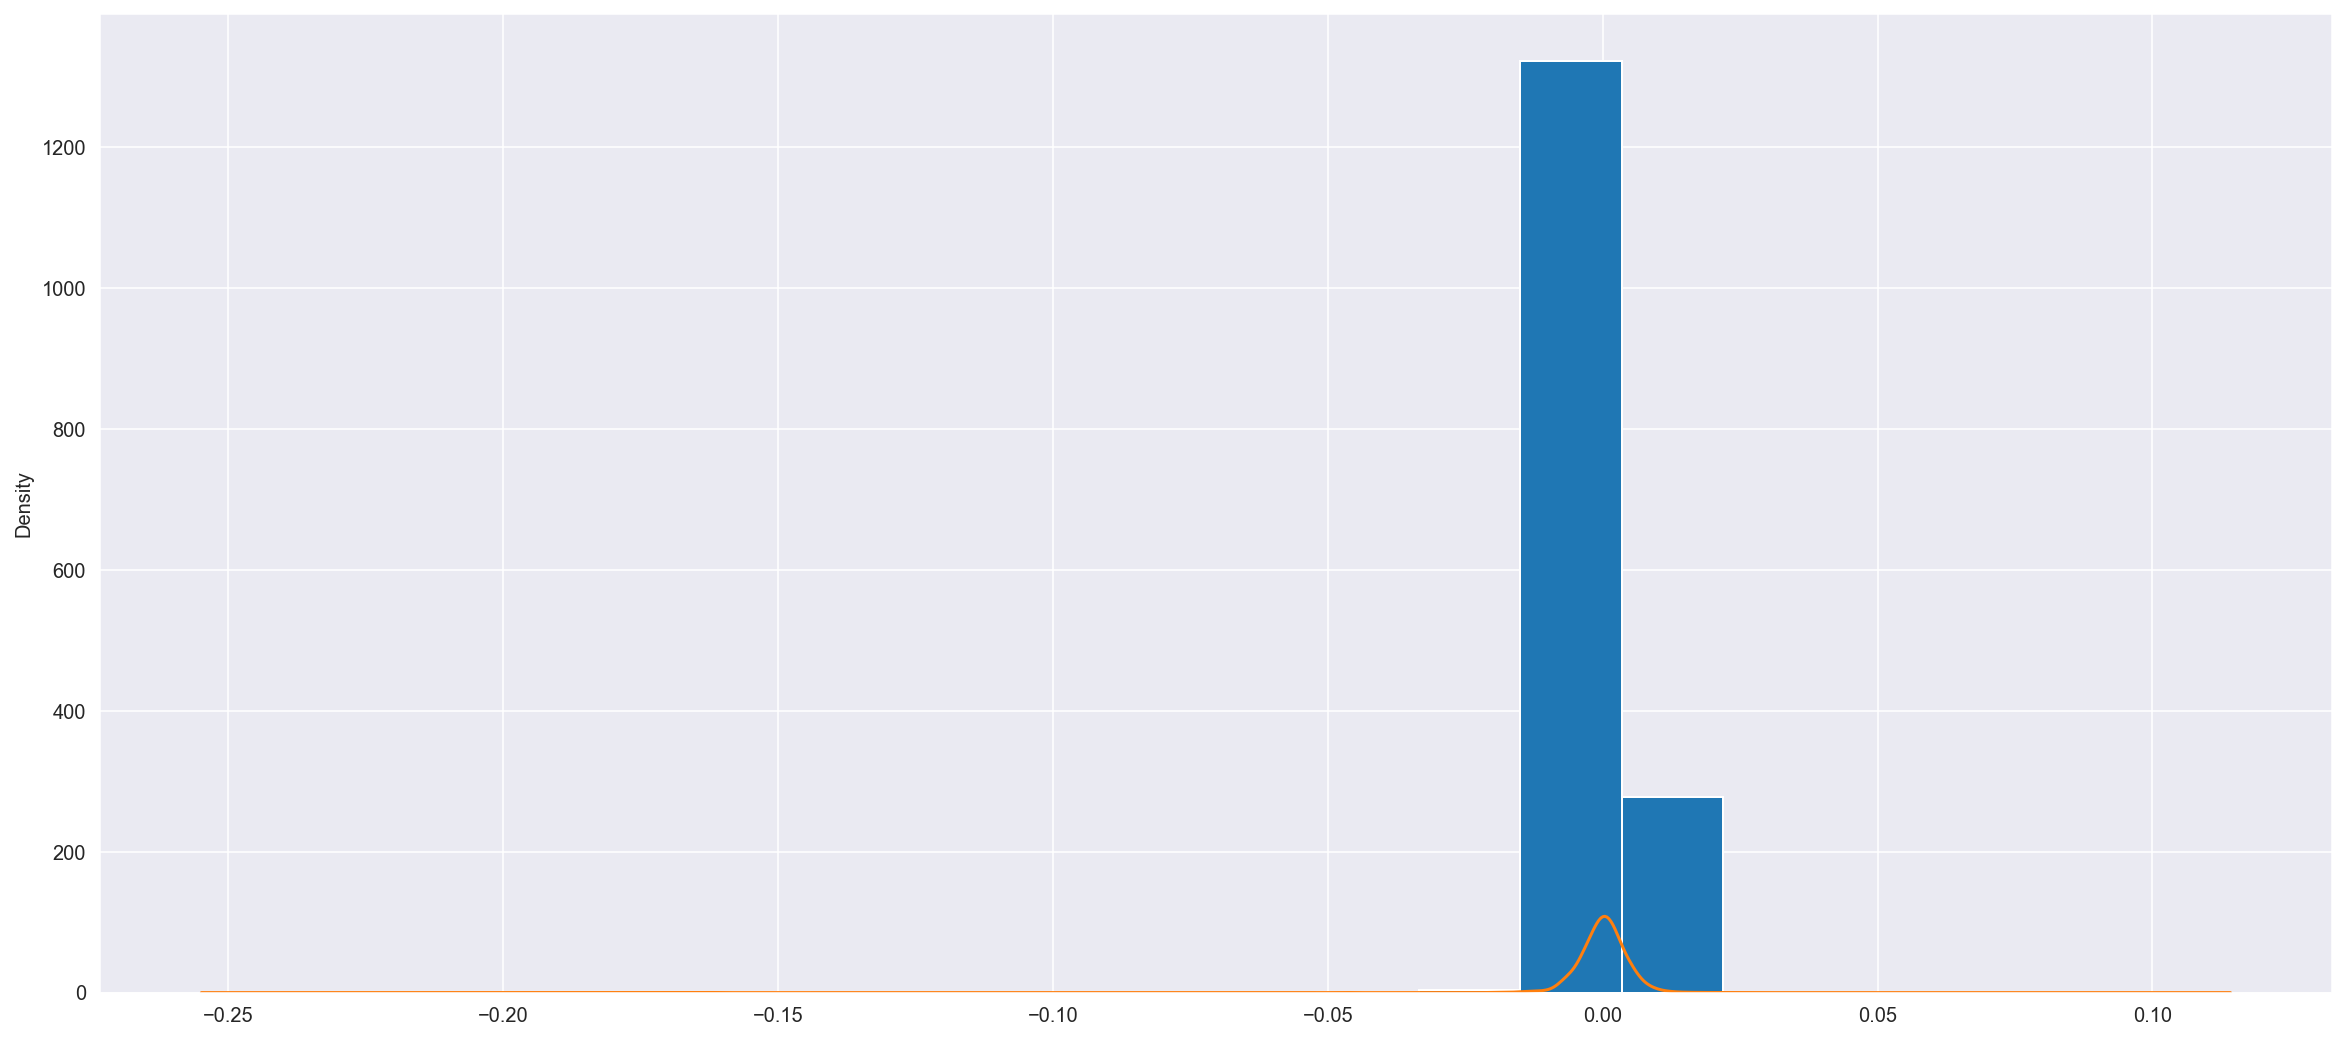

In [37]:
normality_test(resid_m)

Through the graph, we can see residuals are not normally distributed. With the same mean and std, residuals has skewness and kurotosis that are far away from those for a Normal distribution. The residual probably has fat tails.

Possible reason:
- presence of a few large outliers in data
- there might be some other problems (violations) with the model assumptions
- another, better model specification might be better suited for this problem

Potential solution:
- nonlinear transformation of target variable or features
- remove/treat potential outliers
- it can happen that there are two or more subsets of the data having different statistical properties, in which case separate models might be considered. In this factor model case, sometimes, factors are having reversions, meaning that in time period A they may have a positive relation with asset returns, but in period B they may have a negative relation with asset returns. 

### So far:
In short, runing a FF5 model with OLS gives us a taste of which market factors may be useful in predicting AQR fund return, and we saw, from those factor exposures, how AQR fund QMNXI possibily contructs its portfolio. Its preferences over stocks. However, this model is far away from having a predictive power. There are lots of possible reasons, one of which is OLS assumptions are not satisfied really. 

 

Further work, PnL attribution analysis:
- For each factor, calculate what percenatge of QMNIX returns over 2014-10-10 to 2021-02-26 is from that factor.
- How about for each year, are there huge changes in factor attributes over time?


And, Risk attribution analysis
- For each factor, calculate what percentage of QMNIX return risk (variance) is from that factor.
- How about for each year, are there huge changes in factor attributes over time?

In [170]:
# Return attribution:
'''
coeff_m = result_m.params
mults = list(coeff_m)
mults[0] = 1
attr_df = data_all_m*mults
attr_res = attr_df.sum()
attr_res
'''

'\ncoeff_m = result_m.params\nmults = list(coeff_m)\nmults[0] = 1\nattr_df = data_all_m*mults\nattr_res = attr_df.sum()\nattr_res\n'

In next section, we will do a similar factor analysis but with FF 10 industry portfolio factors.

------------------------------
# PART TWO: 10 Industry Portfolio Model

### Datasets
**Portfolio10**:
- Daily data of the [10 Industry Portfolio model](https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/det_10_ind_port.html)
- [Ken French data library](https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html)
- 1926-07-01 to 2021-02-28

### Goal:
Repeat the analysis again, to explore the relationship between AQR returns and different industries.

### I. Data Gathering & EDA

In [104]:
portfolio10_m = web.DataReader('10_Industry_Portfolios_daily', 'famafrench', start = '1926-07-01', end = '2021-02-28')[0]
print(f"Portfolio daily:{portfolio10_m.shape}")
print(f"missing values: {portfolio10_m.isnull().any().sum()}")
b4, e4 = portfolio10_m.index[0], portfolio10_m.index[-1]
print(f"Starting from {str(b4)[:10]} to {str(e4)[:10]}")

Portfolio daily:(24934, 10)
missing values: 0
Starting from 1926-07-01 to 2021-02-26


In [106]:
start3 = max(b4, b3)
end3 = min(e4, e3)
print('For scatter plots, we need consistent start/end dates for two datasets:')
print('start_date: ', str(start3)[:10])
print('end_date: ', str(end3)[:10])
portfolio10_m_3 = portfolio10_m.loc[start3:end3]
AQR_m_3 = AQR_m.loc[start3:end3]

portfolio_all_m = pd.merge(AQR_m_3, portfolio10_m_3, left_index=True, right_index=True)
print(portfolio_all_m.shape)
portfolio_all_m

For scatter plots, we need consistent start/end dates for two datasets:
start_date:  2014-10-10
end_date:  2021-02-26
(1606, 11)


,Return,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other
Date,,,,,,,,,,,
2014-10-10,0.003017,-0.02,-2.02,-1.13,-1.40,-2.89,-1.02,-0.32,-0.89,0.30,-1.20
2014-10-13,-0.001005,-1.16,-1.94,-1.87,-3.18,-1.37,-1.66,-1.75,-2.19,-0.79,-1.10
2014-10-14,-0.005038,-0.06,1.63,0.79,-1.29,0.43,0.25,0.68,-0.63,0.67,0.59
2014-10-15,-0.006079,-0.79,-0.35,0.14,0.57,-0.37,-0.50,-1.03,-0.35,-0.47,-1.15
2014-10-16,-0.008163,-0.41,1.49,0.79,2.09,-0.34,-0.19,-0.21,-0.23,0.54,0.41
...,...,...,...,...,...,...,...,...,...,...,...
2021-02-22,0.010712,0.15,-5.65,-0.37,3.41,-2.53,1.05,-1.20,-0.84,-1.58,0.81
2021-02-23,0.000000,0.09,-1.92,0.21,1.56,-0.37,0.96,-0.59,-0.65,0.85,0.69
2021-02-24,0.004556,0.42,4.64,1.85,3.66,0.84,0.41,-0.32,0.93,-0.68,1.96


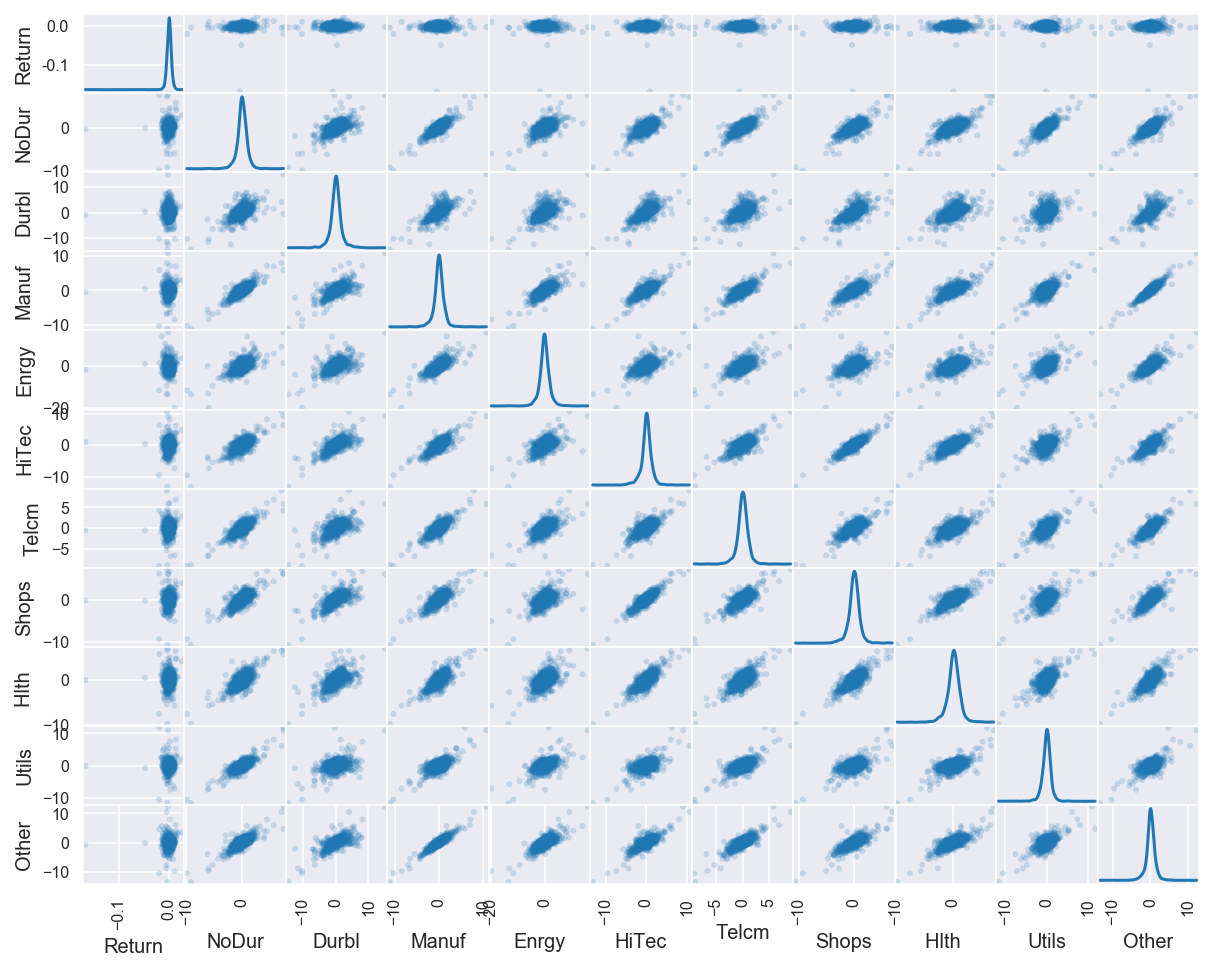

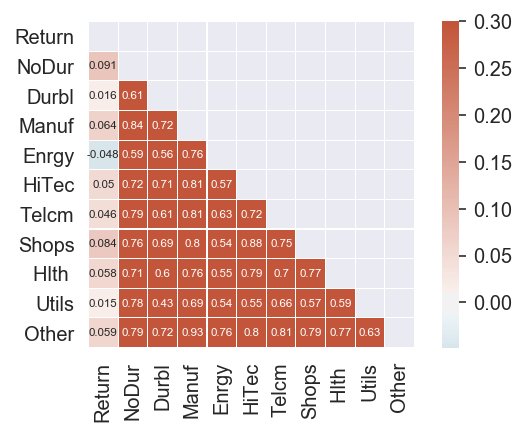

In [107]:
pd.plotting.scatter_matrix(portfolio_all_m, alpha=0.2, figsize=(10,8), diagonal='kde')
V = portfolio_all_m.corr()
mask = np.triu(np.ones_like(V, dtype=bool)) # Generate a mask for the upper triangle
f, ax = plt.subplots(figsize=(5, 3)) # Set up the matplotlib figure
cmap = sns.diverging_palette(230, 20, as_cmap=True) # Generate a custom diverging colormap
sns.heatmap(V, annot=True, annot_kws = {'fontsize':'xx-small'} ,mask=mask, cmap=cmap, vmax=.3, center=0,square=True, linewidths=.01) 

Returns has little correlation with factors. However, the average factor correlation is really high. Most of them are > 0.7.

In [108]:
portfolio_all_m.agg(['mean','std','skew','kurtosis','max','min'])

,Return,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other
mean,-0.000168,0.034763,0.099103,0.052111,0.000255,0.091538,0.042821,0.069315,0.050212,0.030741,0.056756
std,0.006046,1.030511,1.808181,1.263282,2.024474,1.390096,1.117836,1.115819,1.181014,1.243163,1.376873
skew,-13.315866,-0.758937,-0.314557,-0.555052,-0.275352,-0.504547,-0.504404,-0.692539,-0.353375,-0.112222,-0.588891
kurtosis,360.498981,17.276463,10.974063,15.189126,13.737369,12.341272,11.877594,12.480836,7.672512,21.376259,17.970953
max,0.025619,7.450000,15.030000,10.830000,16.000000,10.690000,9.060000,7.050000,6.980000,11.760000,12.240000
min,-0.166690,-9.870000,-14.430000,-11.110000,-19.730000,-13.180000,-9.080000,-10.610000,-9.740000,-11.610000,-13.380000


### II. Regression:
** 10 Industry Portfolio Model**

$$ \text{AQR Return}_i = b_0 + b_1*\text{NoDur}_i + b_2*\text{Durbl}_i + b_3*\text{Manuf}_i + b_4*\text{Enrgy}_i + b_5*\text{HiTec}_i$$
$$ + b_6*\text{Telcm}_i + b_7*\text{Shops}_i + b_8*\text{Hlth}_i + b_9*\text{Utils}_i + b_{10}*\text{Other}_i + \epsilon_i $$

- 1 `NoDur`:  Consumer Nondurables -- Food, Tobacco, Textiles, Apparel, Leather, Toys
- 2 `Durbl`:  Consumer Durables -- Cars, TVs, Furniture, Household Appliances
- 3 `Manuf`:  Manufacturing -- Machinery, Trucks, Planes, Chemicals, Off Furn, Paper, Com Printing
- 4 `Enrgy`:  Oil, Gas, and Coal Extraction and Products
- 5 `HiTec`:  Business Equipment -- Computers, Software, and Electronic Equipment
- 6 `Telcm`:  Telephone and Television Transmission
- 7 `Shops`:  Wholesale, Retail, and Some Services (Laundries, Repair Shops)
- 8 `Hlth`:   Healthcare, Medical Equipment, and Drugs
- 9 `Utils`:  Utilities
- 10 `Other`:  Other -- Mines, Constr, BldMt, Trans, Hotels, Bus Serv, Entertainment, Finance

In [41]:
# regressors: 10 Factors
X_portfolio_m = portfolio_all_m[portfolio_all_m.columns[1:]]   
# response variable: Returns of QMNIX Daily
y_portfolio_m = portfolio_all_m[['Return']]

In [42]:
# Running OLS model:
import statsmodels.api as sm
X_portfolio_m = sm.add_constant(X_portfolio_m)
model_p_m = sm.OLS(y_portfolio_m, X_portfolio_m, missing='raise')
result_p_m = model_p_m.fit()

tstat_p_m = result_p_m.tvalues
coeff_p_m = result_p_m.params
fitted_p_m = result_p_m.fittedvalues
resid_p_m = result_p_m.resid
result_p_m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Return   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     7.008
Date:                Sun, 18 Apr 2021   Prob (F-statistic):           7.72e-11
Time:                        11:07:43   Log-Likelihood:                 5960.1
No. Observations:                1606   AIC:                        -1.190e+04
Df Residuals:                    1595   BIC:                        -1.184e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.000     -1.420      0.156      -0.001    8.04e-05
NoDur          0.0010      0.000      3.150      0.002       0.000       0.002
Durbl         -0.0003      0.000     -2.255      0.024      -0.001   -3.77e-05
Manuf          0.0008      0.000      1.921      0.055   -1.59e-05       0.002
Enrgy         -0.0006      0.000     -5.271      0.000      -0.001      -0.000
HiTec         -0.0005      0.000     -1.995      0.046      -0.001   -8.65e-06
Telcm         -0.0003      0.000     -1.236      0.217      -0.001       0.000
Shops          0.0007      0.000      2.091      0.037    4.03e-05       0.001
Hlth        1.377e-05      0.000      0.060      0.952      -0.000       0.000
Utils         -0.0006      0.000     -3.057      0.002      -0.001      -0.000
Other          0.0005      0.000      1.611      0.107      -0.000       0.001
==============================================================================
Omnibus:                     3102.777   Durbin-Watson:                   1.931
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         10263618.728
Skew:                         -14.196   Prob(JB):                         0.00
Kurtosis:                     393.606   Cond. No.                         11.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Fitted Model:
$$ \hat{\text{AQR Return}_i} = -0.0002 + 0.0010*\text{NoDur}_i -0.0003*\text{Durbl}_i + 0.0008*\text{Manuf}_i -0.0006*\text{Enrgy}_i -0.0005*\text{HiTec}_i$$
$$ -0.0003*\text{Telcm}_i + 0.0007*\text{Shops}_i + 0.00001377*\text{Hlth}_i -0.0006*\text{Utils}_i + 0.0005*\text{Other}_i$$

**t-test**: 
- given all the others are significant, `NoDur`, `Durbl`, `Enrgy`, `HiTec`, `Shops` and `Utils` are statistically significant in their own individual t-test. 
- `const`, `Manuf`, `Telcm`, `Hlth` and `Other` are not sigificant.

Industry Interpret:
- the `NoDur` exposure is significantly positive and is the greaest among all, meaning that the fund has most of its exposure to Consumer Nondurables industry. most sensitive to the performance of this industry. We may guess its portfolio has assets from companies of Food, Tobacco, Textiles, Apparel, Leather, Toys. 
- the `Durbl` Consumer Durables exposure is however, significantly negative. We can tell that the fund probabily has a negative attitude on assets such as Cars, TVs, Furniture, Household Appliances.
- `Manuf` Manufacturing factor is not significant given other factors are in our model. This makes sense since from the correlation matrix, we can see `Manuf` are highly correlated with almost all of other factors. But at least, we found a small (0.0008) sensitivity of AQR fund with assets in Machinery, Trucks, Planes, Chemicals, Off Furn, Paper, Com Printing.
- `Enrgy` is significant negative. AQR will decrease as assets in Oil, Gas, and Coal Extraction and Products increases. But this change won't be large. 
- Smilar with Energy industry, `HiTec` refering to Business Equipment industry also has a significantly negative coefficient. Therefore, given other portfolios are in our model, assets from Computers, Software, and Electronic Equipment companies still has a small impact on AQR fund return. 
- `Telcm` is again insignificant. This tells us Telephone and Television Transmission may has no influence as other industries are explaining on AQR fund returns. This may be due to its high correlation with other factors.
- `Shops` is positively significant, which means the great performance in Wholesale, Retail, and Some Services (Laundries, Repair Shops) would be a part of our fund return. 
- The fund expoure to `Hlth`, Healthcare, Medical Equipment, and Drugs, is really small and insignificant. 
- `Utils` Utilities industry is significantly negatively related with fund return. 
- `Other` industry including Mines, Constr, BldMt, Trans, Hotels, Bus Serv, Entertainment, Finance. AQR fund may not include assets from many  of these sectors. 

**F-test**: 
- p-value = 7.72e-11 < 0.05 and hence we reject null, concluding that our model outperforms the intercept only model.
- Luckliy, even though there are some factors are insignificant and may should be given up, these 10 industry factors are jointly significant in explaining the AQR fund daily returns.

**$R^2$**: 
- 0.042 means the model is not great with explaining return variance. 
- Even worse than 5 factor model (0.063). We are again losing the predictive power.

### III. Classic Linear Regression Assumptions Testing

#### Test Linearity:

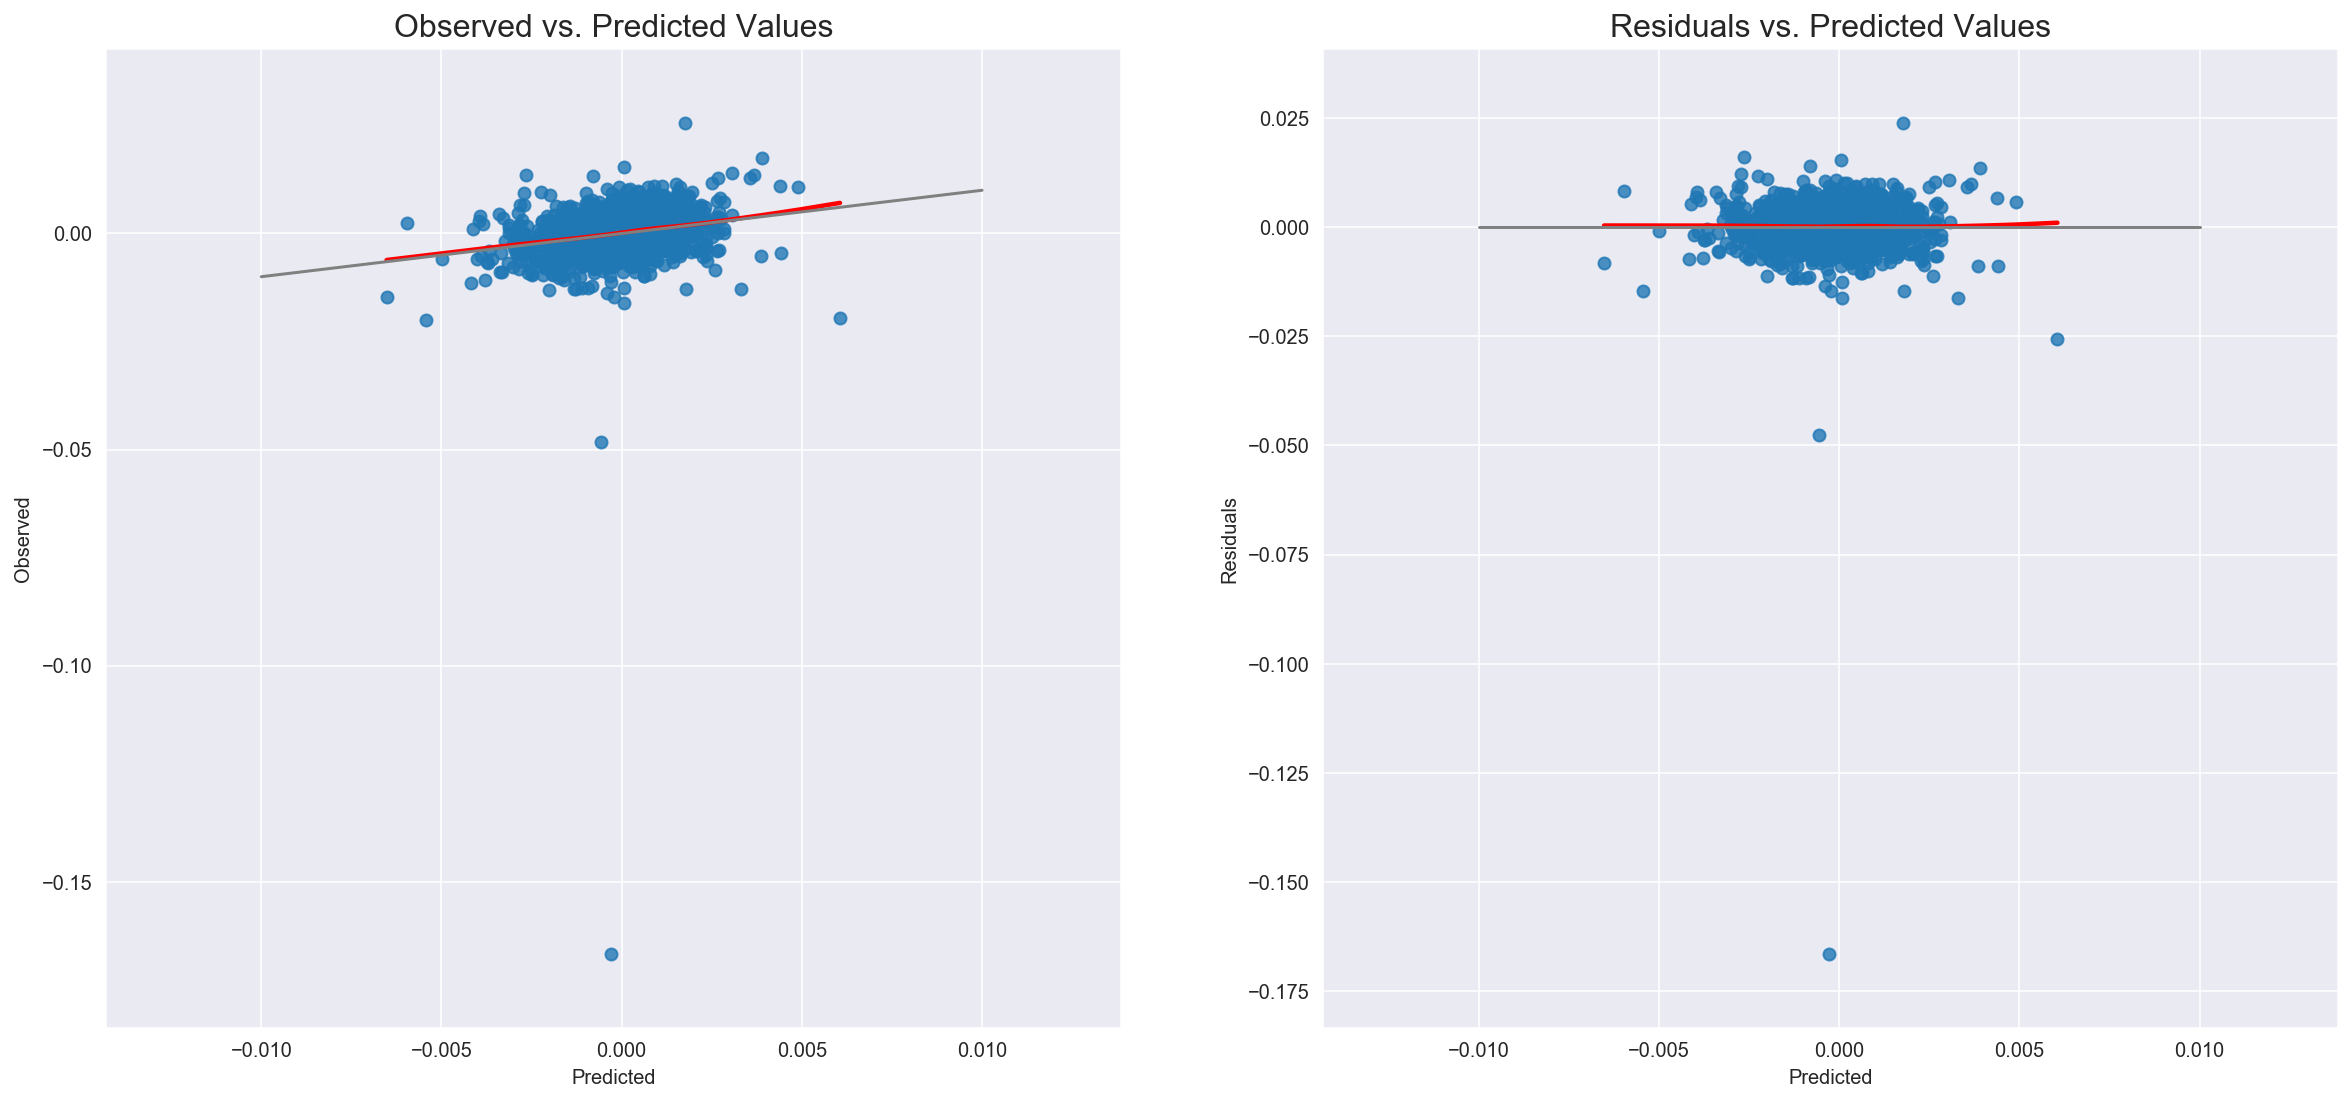

In [43]:
linearity_test(result_p_m, y_portfolio_m) 

Linearity is roughly satisfied since there is no bowl-shaped pattern indicating the model is making unusual large/small predictions. 

#### Test Strict exogeneity:
- error terms has zero mean 
- doesn’t depend on the independent variables X. i.e. there must be no relationship between the X and the error term.

In [44]:
print(f"mean of residuals = {resid_p_m.mean()}")

mean of residuals = 2.0738910796235802e-19


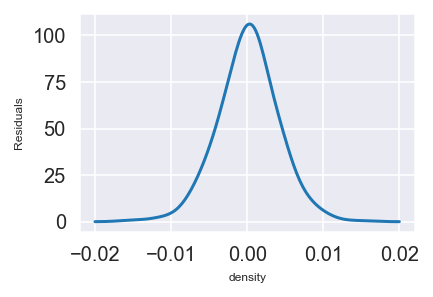

In [109]:
plt.figure(figsize=(3,2))
density = gaussian_kde(resid_p_m)
xs = np.linspace(-0.02,0.02,200)
density.covariance_factor = lambda : .25
density._compute_covariance()
plt.ylabel("Residuals", fontsize=6)
plt.xlabel("density", fontsize=6)
plt.plot(xs,density(xs))
plt.show()

In [46]:
pearson_corr_test(X_portfolio_m, resid_p_m)

Performing Pearson Correlation Test ...
NoDur 
 correlation: 2.69335134373989e-16 
 p-value: 1.0000000000008598
 Fail to rej null, conclude non-correlated

Durbl 
 correlation: 3.4170267187229877e-16 
 p-value: 1.0000000000008633
 Fail to rej null, conclude non-correlated

Manuf 
 correlation: 2.553285376565852e-16 
 p-value: 1.0000000000008598
 Fail to rej null, conclude non-correlated

Enrgy 
 correlation: 1.9649078203154355e-16 
 p-value: 1.0000000000008598
 Fail to rej null, conclude non-correlated

HiTec 
 correlation: 3.155400739405031e-16 
 p-value: 1.0000000000008633
 Fail to rej null, conclude non-correlated

Telcm 
 correlation: 2.8161076342332004e-16 
 p-value: 1.0000000000008633
 Fail to rej null, conclude non-correlated

Shops 
 correlation: 2.9921301381278104e-16 
 p-value: 1.0000000000008633
 Fail to rej null, conclude non-correlated

Hlth  
 correlation: 2.566642778711791e-16 
 p-value: 1.0000000000008598
 Fail to rej null, conclude non-correlated

Utils 
 correlation: 

Strict exogeneity is satisfied.

#### Test No Multicollinearity:

In [47]:
# bivariate correlation
portfolio10_m_3.corr()

,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other
NoDur,1.000000,0.609421,0.836017,0.590057,0.724551,0.787322,0.762017,0.712356,0.779554,0.787068
Durbl,0.609421,1.000000,0.724403,0.563068,0.710368,0.605774,0.692263,0.597911,0.427165,0.723210
Manuf,0.836017,0.724403,1.000000,0.758563,0.814286,0.806055,0.795540,0.764108,0.687297,0.930921
Enrgy,0.590057,0.563068,0.758563,1.000000,0.570372,0.627980,0.543758,0.548570,0.536045,0.761328
HiTec,0.724551,0.710368,0.814286,0.570372,1.000000,0.723247,0.878377,0.793653,0.547951,0.803040
Telcm,0.787322,0.605774,0.806055,0.627980,0.723247,1.000000,0.747719,0.700704,0.656090,0.813765
Shops,0.762017,0.692263,0.795540,0.543758,0.878377,0.747719,1.000000,0.765978,0.571866,0.789415
Hlth,0.712356,0.597911,0.764108,0.548570,0.793653,0.700704,0.765978,1.000000,0.591914,0.765090
Utils,0.779554,0.427165,0.687297,0.536045,0.547951,0.656090,0.571866,0.591914,1.000000,0.631713
Other,0.787068,0.723210,0.930921,0.761328,0.803040,0.813765,0.789415,0.765090,0.631713,1.000000


In [48]:
VIF_test(X_portfolio_m)

,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other
vif,5.326717,2.456764,11.112542,2.690649,5.922488,3.731577,5.506307,3.300608,2.769162,9.512111


No Multicollinearity is NOT satisfied due to the relatively high correlations between 
- Manuf and NoDur
- HiTec and NoDur
- Telcm and NoDur
- Shops and NoDur
- Others and NoDur
- etc (any > 0.7)

VIF furtherly confirms this result. This outcome makes sense when we have more and more factors which is common nowadays. Usually, we want to address this Multicollinearity problem by using more advanced ML techniques to perform dimenstion reduction and factor selection.

#### Test Spherical error variance:
- constance residual variance
- no autocorrelation in residuals

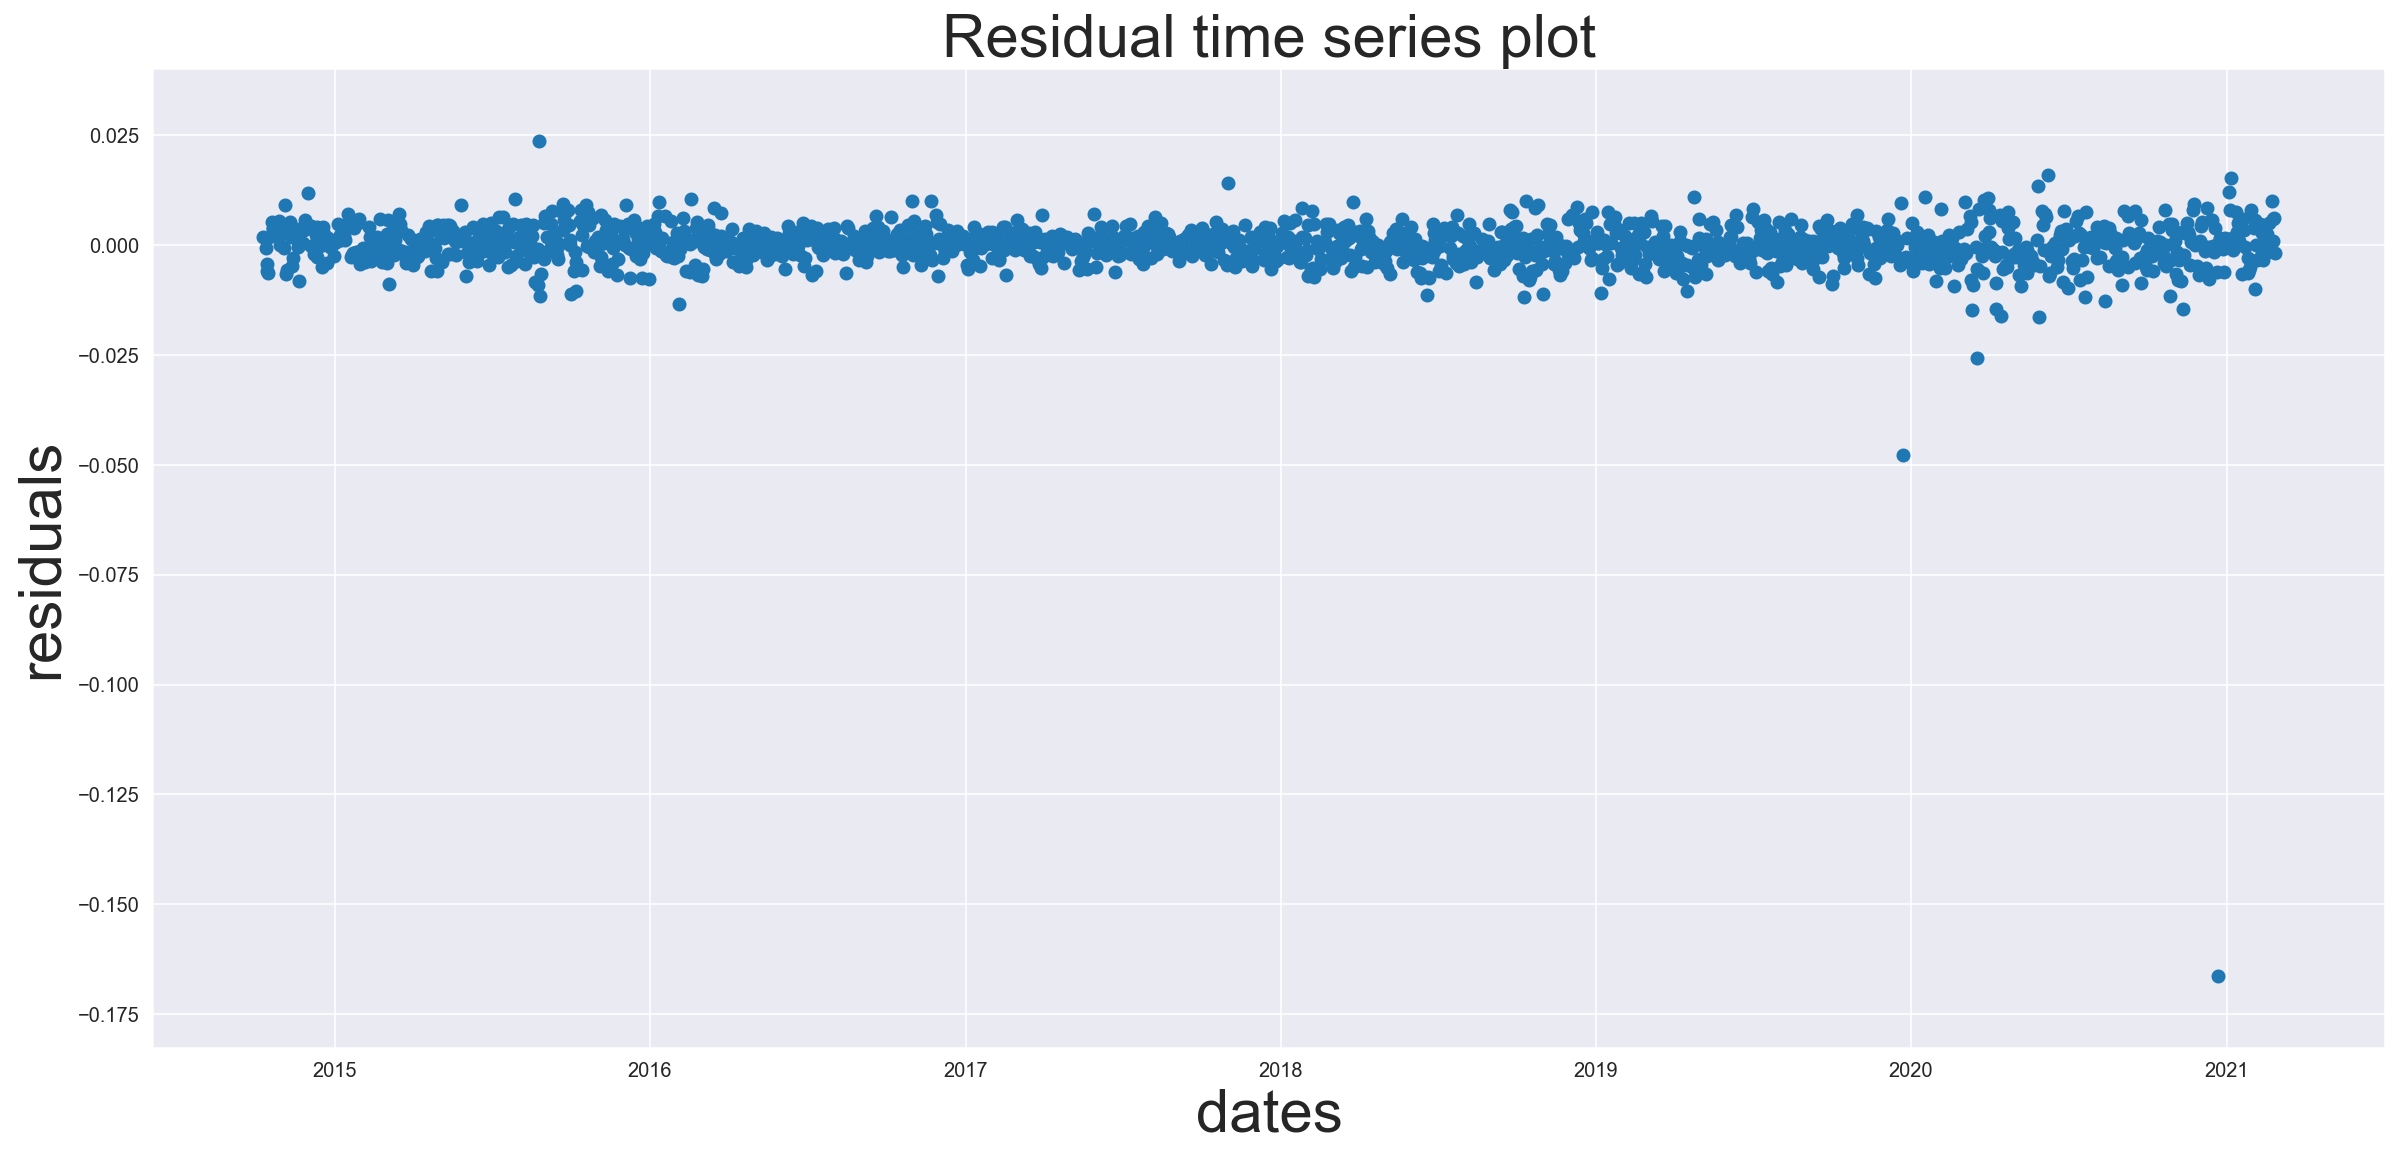

In [49]:
# to see constant variance of error terms
plt.scatter(y = resid_p_m, x = portfolio10_m_3.index)
plt.title('Residual time series plot', fontsize = 30)
plt.ylabel('residuals', fontsize = 30)
plt.xlabel('dates', fontsize = 30)
plt.show()


---- Breusch-Pagan test ----
                                  value
Lagrange multiplier statistic  6.217089
p-value                        0.796706
f-value                        0.619850
f p-value                      0.798017
Fail to Reject Null, conclude homoscedasticity

---- Goldfeld-Quandt test ----
                     value
F statistic   5.330579e+00
p-value      6.178674e-111
Reject Null, conclude heteroscedasticity

---- Residuals plots ----


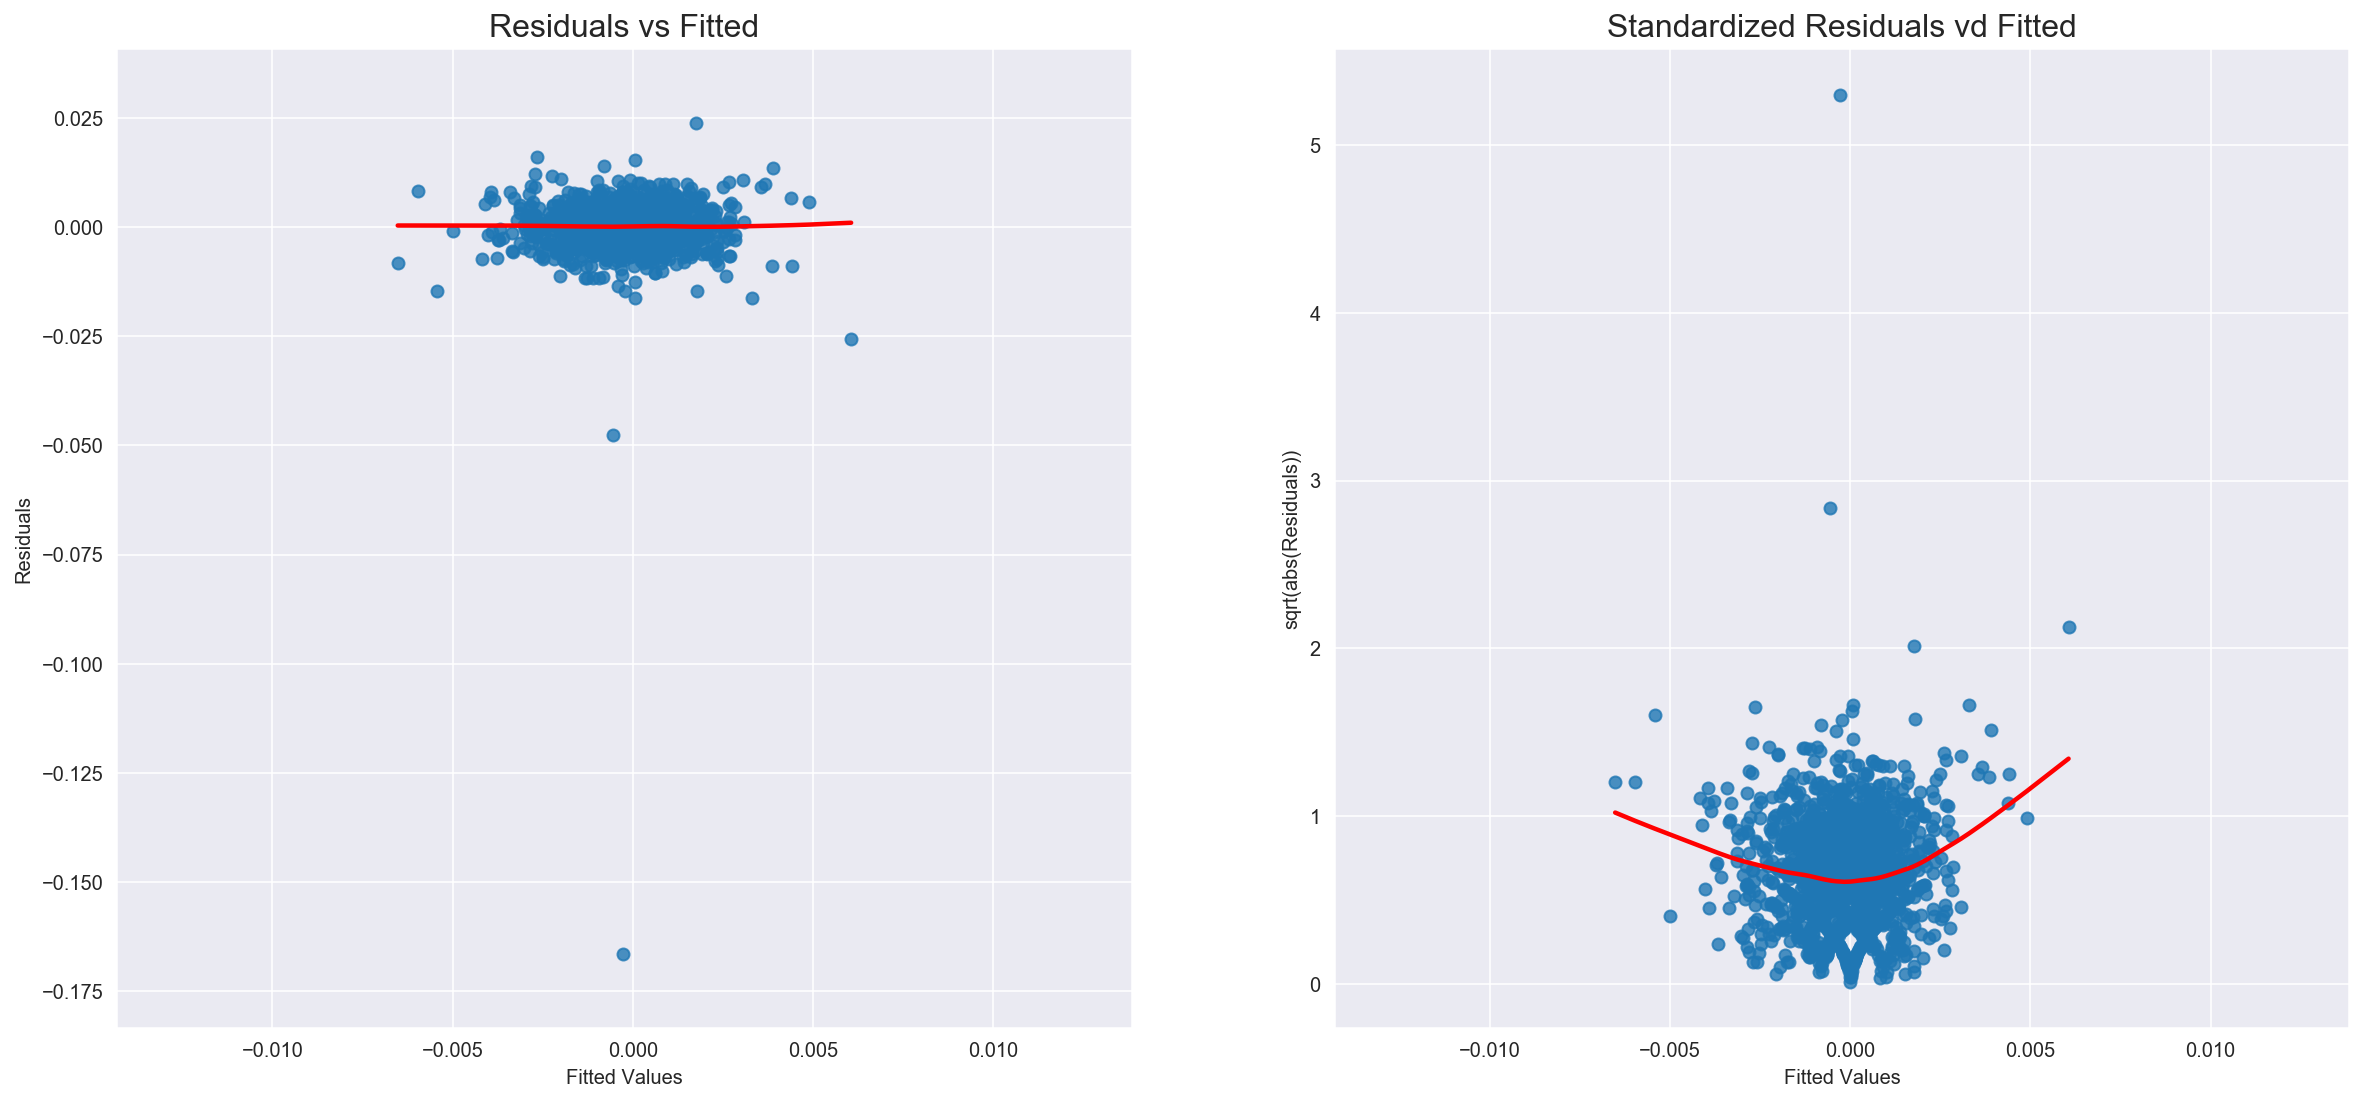

In [50]:
homoscedasticity_test(result_p_m)

Durbin-Watson: 1.9623593087965796
Little to no autocorrelation 

Assumption satisfied


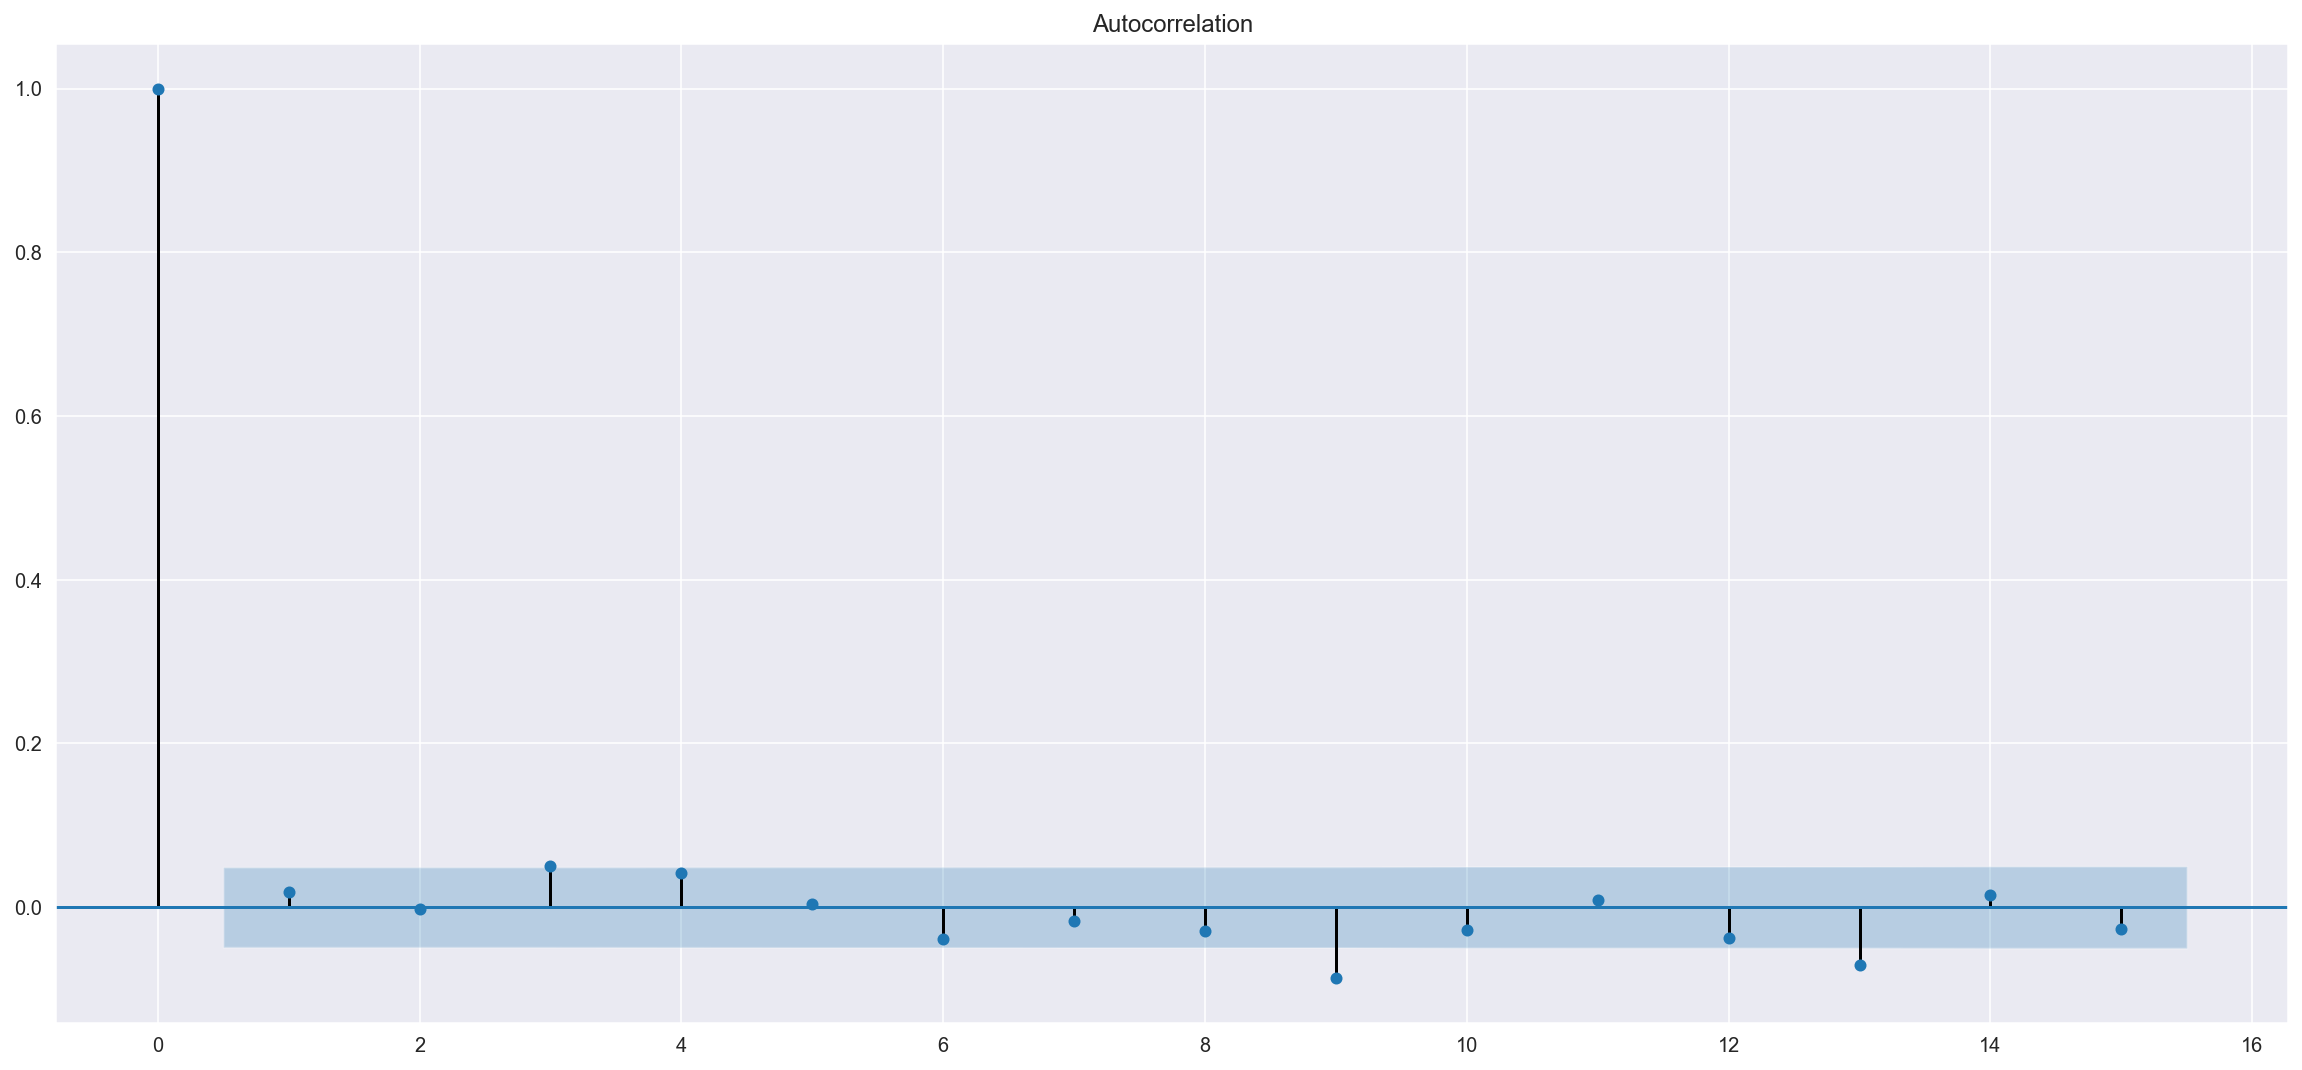

In [51]:
# check autocorrelation of error terms
autocorrelation_test(resid_m)

Variance is not constant, no autocorrelation though.

#### Test Normality:

In [52]:
print(f'residual mean: {resid_p_m.mean()}')
print(f'residual std: {resid_p_m.std()}')
s = pd.DataFrame(np.random.normal(resid_p_m.mean(), resid_p_m.std(), len(resid_p_m)))
print(f'skewness: \n   residual: {resid_p_m.skew()} \n   normal: {s[0].skew()}')
print(f'kurtosis: \n   residual: {resid_p_m.kurtosis()} \n   normal: {s[0].kurtosis()}')

residual mean: 2.0738910796235802e-19
residual std: 0.005917780424737924
skewness: 
   residual: -14.209270135692037 
   normal: -0.0011769905340771713
kurtosis: 
   residual: 391.8285050488637 
   normal: 0.1913859364156143


Non-normal


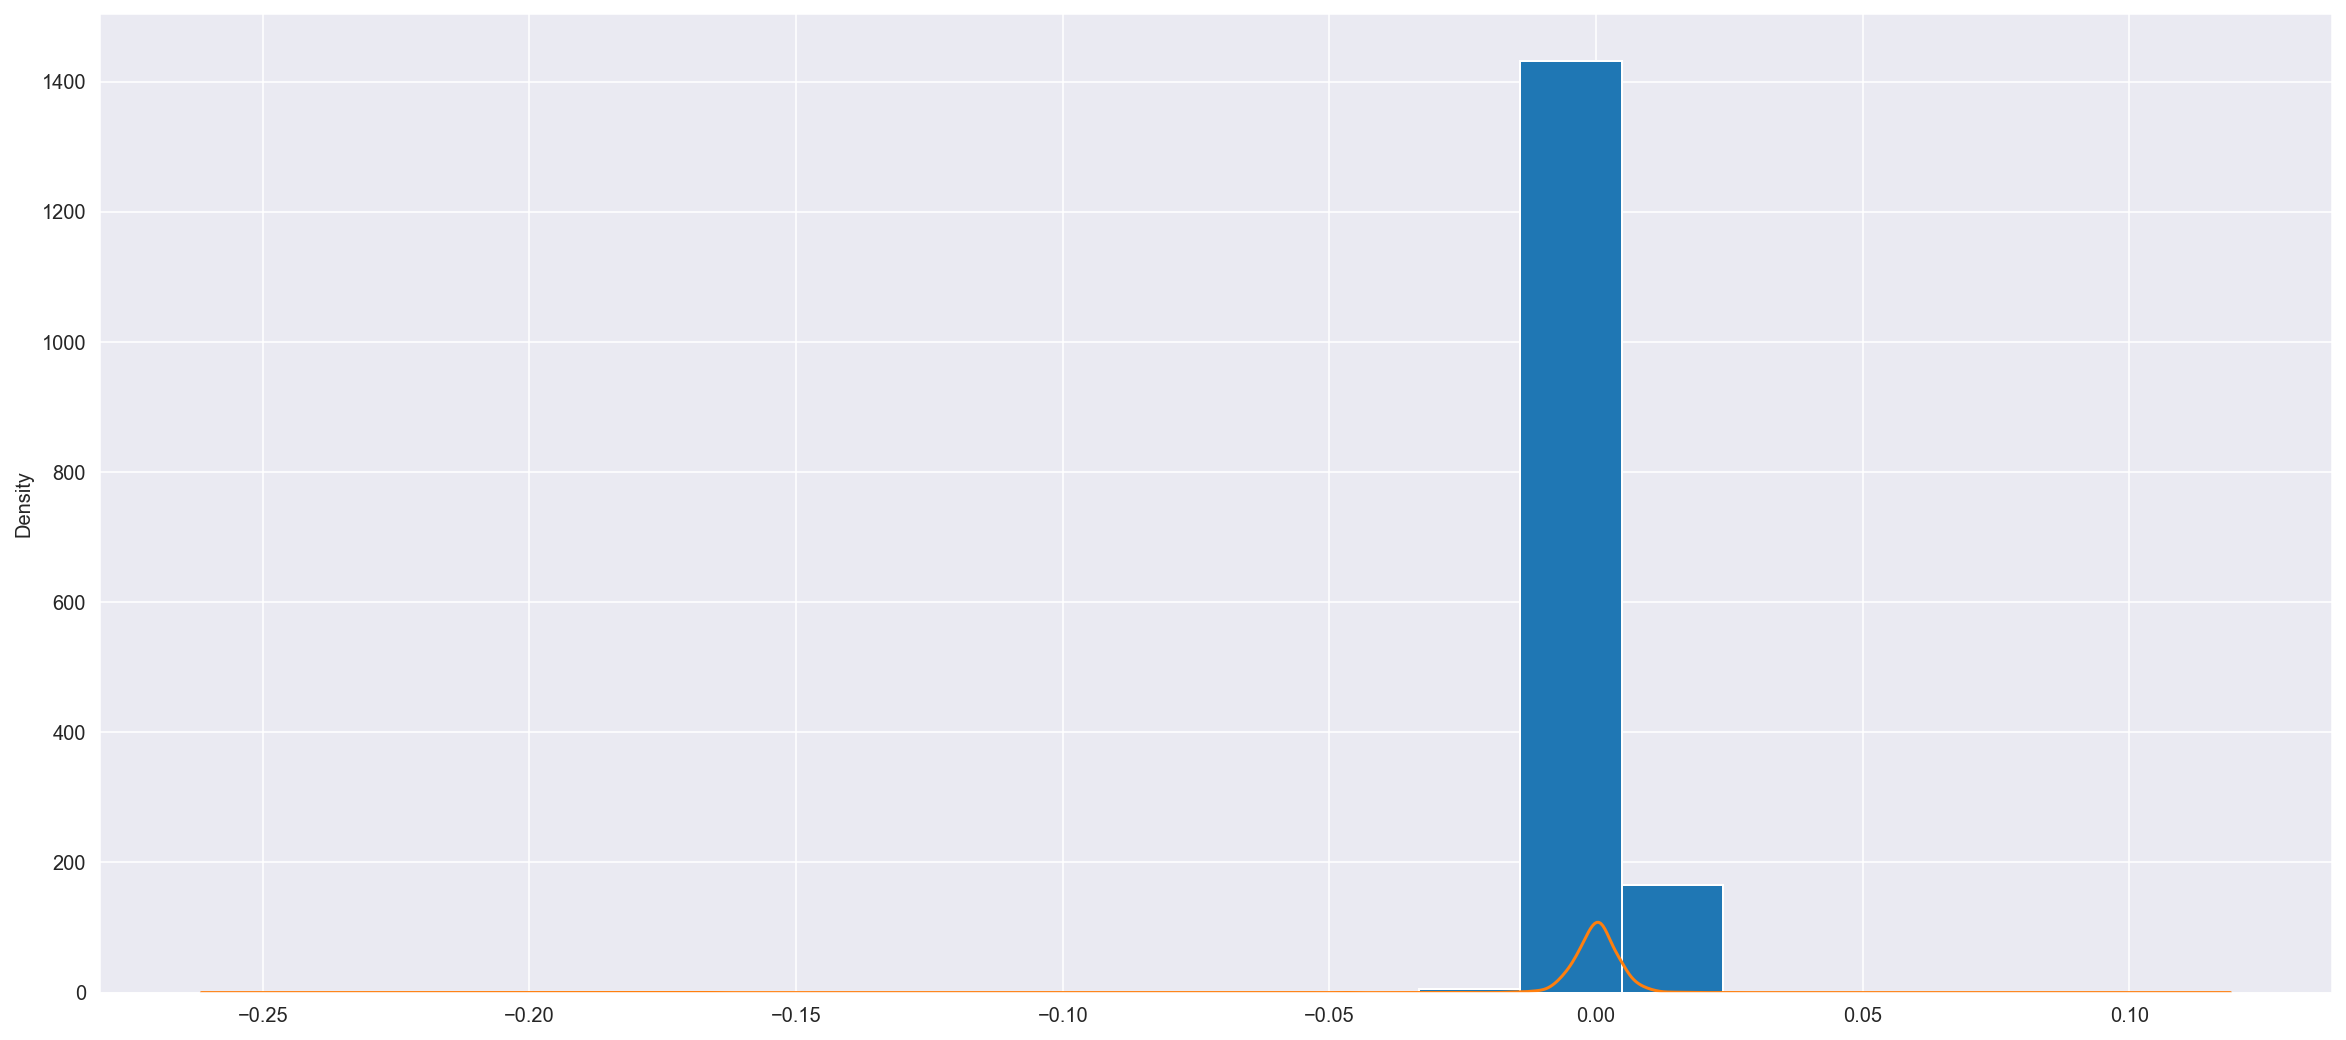

In [110]:
normality_test(resid_p_m)

Residual normality is not satisfied. It is more likely having fat tails, which means even though OLS is setted up without problem, the standard error, t-statistics and F-stats results are not relible. Confidence intervals are either too wide or too narrow. 


### To end up 10 Industry Portfolio analysis 

Bad thing:

OLS assumptions do not perform well in daily 10 industry portfolio scenario since 
- there are some industries are highly correlated with each other
    - when multicollinearity appears, we can run GLS, WLS or FGLS
- heteroscedasticity, residual variance is not constant
- residuals are not normal distributed

Even though 10 factors jointly useful in explaining AQR returns, that model cannot be used to predict returns due to a low R-squared. No power of predictions. 

Good things:
- We found the exposures to 10 industry portfolio factors for AQR fund, some factors are powerful attributes to fund return.
    - `NoDur`: 0.0010, Consumer Nondurables -- Food, Tobacco, Textiles, Apparel, Leather, Toys
    - `Durbl`: -0.0003, Consumer Durables -- Cars, TVs, Furniture, Household Appliances
    - `Enrgy`: -0.0006, Oil, Gas, and Coal Extraction and Products
    - `HiTec`: -0.0005, Business Equipment -- Computers, Software, and Electronic Equipment
    - `Shops`: 0.0007, Wholesale, Retail, and Some Services (Laundries, Repair Shops)
    - `Utils`: -0.0006, Utilities

One take-away:

when doing research on industry portfolios, we need to pay attention on the relationships among industries. In other words, when we allocate our portfolio, we want not only to optimize upon equity returns, but also pay attention to equity industry to ensure an enough diversification of our portfolio. 

## Recap:
What we have done in this notebook is exploring the AQR Equity Market Neutral Fund QMNXI and its relationship with Fama-French 5 Factors and Fama-French 10 Industry Portfolio Factors.

The data we used are in daily frequency from 2014-10-10 to 2021-02-26.

The model we exployed is simple linear regression with OLS esimation. 

Through analysis, we found QMNXI return is possibly driven by 
- Market return, small cap companies, conservative investment portfolios
- Consumer Nodurables, Consumer DUrables, Energy, Business Equipment, Shops and Utility industry.

The modeling part can be improved in many ways that are mention above. (possible solutions)